<a href="https://colab.research.google.com/github/carolinaenriqz/Optimization-Algorithms-for-Uncertain-Knapsack-Problem/blob/1stStageVariables-Reduced/28_08_TFG_CE_GeneracionDatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## cargar datos de github e importar librerias

In [1]:
!pip -q install XlsxWriter
!pip install mip

!git clone --depth 1 https://github.com/likr/kplib.git

import os
import pandas as pd
from IPython.display import display

BASE_DIR = "/content/kplib/00Uncorrelated"
n_values = ["n00050", "n00100", "n00200", "n00500"]
tipo_instancia = "R01000"

instancias = []
for n in n_values:
    ruta = os.path.join(BASE_DIR, n, tipo_instancia)
    if not os.path.isdir(ruta):
        print(f"Ruta no encontrada: {ruta}")
        continue

    archivos = sorted([f for f in os.listdir(ruta) if f.lower().endswith('.kp')])[:15]

    for archivo in archivos:
        ruta_archivo = os.path.join(ruta, archivo)
        try:
            with open(ruta_archivo, 'r') as f:
                lineas = f.readlines()

            num_items = int(lineas[1].strip())
            capacidad = int(lineas[2].strip())
            items = [tuple(map(int, linea.strip().split()))
                     for linea in lineas[4:] if linea.strip()]

            if len(items) != num_items:
                print(f"Advertencia: en {archivo} se esperaban {num_items} ítems pero se leyeron {len(items)}")
                continue

            valores, pesos = zip(*items)
            instancias.append({
                "n": num_items,
                "Capacidad": capacidad,
                "Utilidades": list(valores),
                "Pesos": list(pesos),
                "Archivo": archivo
            })
        except Exception as e:
            print(f"Error al leer {archivo}: {e}")

df_kplib = pd.DataFrame(instancias)
print(f"Instancias cargadas: {df_kplib.shape}")
df_kplib = df_kplib[["Archivo", "n", "Capacidad", "Utilidades", "Pesos"]]
display(df_kplib.head(10))









   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.1/484.1 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 59.0 MB/s eta 0:00:00
  Created wheel for cffi: filename=cffi-1.15.0-cp312-cp312-linux_x86_64.whl size=400942 sha256=5b0cc045bbfc6d4d8cfb76cb16d1a365732cb75c3e5652fc0457564704d1d729
  Stored in directory: /root/.cache/pip/wheels/b9/d6/15/0950847bf7d74ea5f0380b8b23a1d81b45bdf48488b4b8237a
Successfully built cffi
  Attempting uninstall: cffi
    Found existing installation: cffi 1.17.1
    Uninstalling cffi-1.17.1:
      Successfully uninstalled cffi-1.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pygit2 1.18.2 requires cffi>=1.17.0, but you have cffi 1.15.0 which is incompatible.
rpy2 3.5.17 requires 

,Archivo,n,Capacidad,Utilidades,Pesos
0,s000.kp,50,14778,"[845, 758, 421, 259, 512, 405, 784, 304, 477, ...","[804, 448, 81, 321, 508, 933, 110, 552, 707, 5..."
1,s001.kp,50,13598,"[135, 848, 764, 256, 496, 450, 652, 789, 94, 2...","[304, 588, 883, 847, 506, 590, 35, 243, 798, 4..."
2,s002.kp,50,13810,"[957, 948, 57, 85, 836, 736, 670, 309, 606, 60...","[491, 925, 501, 832, 354, 883, 900, 462, 568, ..."
3,s003.kp,50,13596,"[238, 545, 370, 604, 626, 66, 14, 838, 260, 23...","[682, 929, 857, 991, 672, 164, 861, 965, 905, ..."
4,s004.kp,50,11618,"[237, 104, 397, 155, 67, 402, 918, 801, 766, 2...","[281, 535, 472, 343, 998, 196, 413, 203, 633, ..."
5,s005.kp,50,11922,"[623, 742, 796, 943, 740, 923, 30, 466, 944, 6...","[338, 310, 819, 481, 316, 482, 705, 58, 976, 2..."
6,s006.kp,50,12044,"[794, 822, 486, 262, 1, 663, 471, 760, 374, 77...","[881, 526, 117, 663, 313, 197, 484, 139, 210, ..."
7,s007.kp,50,12828,"[324, 151, 651, 73, 536, 366, 58, 508, 38, 434...","[981, 119, 419, 758, 152, 489, 40, 669, 765, 5..."
8,s008.kp,50,10985,"[227, 963, 127, 705, 86, 248, 1000, 210, 642, ...","[703, 950, 844, 504, 198, 151, 529, 510, 72, 9..."
9,s009.kp,50,11487,"[464, 374, 139, 867, 7, 503, 899, 81, 555, 617...","[84, 540, 18, 85, 497, 921, 421, 399, 639, 94,..."


## sp model

In [ ]:
import time
import numpy as np
import pandas as pd
from mip import Model, CONTINUOUS, MAXIMIZE, CBC, OptimizationStatus


seed = 123
n_smpl = 8
sizes = (50, 100, 200, 500)
# sizes = (50,200)
k = 20



def solve_sp(bar_c, pesos, capacidad, pct_desviacion, split, t, n_smpl, seed=123, verbose=False):
    # --- Normaliza split_A segun t (parche minimo) ---
    # split_A marcador original: [0.0, 0.5, 0.25, 0.25]
    if isinstance(split, (list, tuple)) and len(split) == 4 and np.allclose(split, [0.0, 0.5, 0.25, 0.25]):
        if t == 1:
            split = [1.0, 0.0, 0.0, 0.0]
        elif t == 2:
            split = [0.5, 0.5, 0.0, 0.0]
        elif t == 3:
            split = [0.25, 0.5, 0.25, 0.0]
        else:  # t == 4
            split = [0.0, 0.5, 0.25, 0.25]
    pct_x1, pct_x2, pct_x3, pct_x4 = split
    solver_name = CBC
    time_limit = 360000000
    n = len(bar_c)
    n_x1, n_x2, n_x3 = (int(round(pct_x1*n)), int(round(pct_x2*n)), int(round(pct_x3*n))); n_x4 = n - (n_x1 + n_x2 + n_x3)
    c1, c2, c3, c4 = (np.array(bar_c[:n_x1], float), np.array(bar_c[n_x1:n_x1+n_x2], float), np.array(bar_c[n_x1+n_x2:n_x1+n_x2+n_x3], float), np.array(bar_c[n_x1+n_x2+n_x3:n], float))
    w1, w2, w3, w4 = (np.array(pesos[:n_x1], float), np.array(pesos[n_x1:n_x1+n_x2], float), np.array(pesos[n_x1+n_x2:n_x1+n_x2+n_x3], float), np.array(pesos[n_x1+n_x2+n_x3:n], float))
    rng = np.random.default_rng(seed)
    def _lh(v, delta):
        low, high = v*(1-delta), v*(1+delta)
        return np.minimum(low, high), np.maximum(low, high)
    low2, high2 = _lh(c2, pct_desviacion); U2_base = rng.uniform(low2, high2, size=(n_smpl, n_x2))
    low3, high3 = _lh(c3, pct_desviacion); U3_base = rng.uniform(low3, high3, size=(n_smpl, n_x3))
    low4, high4 = _lh(c4, pct_desviacion); U4_base = rng.uniform(low4, high4, size=(n_smpl, n_x4))
    mu2 = U2_base.mean(axis=0) if U2_base.size else np.array([], float)
    mu3 = U3_base.mean(axis=0) if U3_base.size else np.array([], float)
    mu4 = U4_base.mean(axis=0) if U4_base.size else np.array([], float)
    tile3 = np.tile(mu3, (n_smpl, 1)) if mu3.size else np.zeros((n_smpl, 0), float)
    tile4 = np.tile(mu4, (n_smpl, 1)) if mu4.size else np.zeros((n_smpl, 0), float)
    tile3 = np.tile(c3, (n_smpl, 1)) if c3.size else np.zeros((n_smpl, 0), float)
    tile4 = np.tile(c4, (n_smpl, 1)) if c4.size else np.zeros((n_smpl, 0), float)
    S2 = S3 = S4 = n_smpl
    p2 = p3 = p4 = 1.0 / n_smpl

    # ---------- t == 1 ----------
    if t == 1:
        mean2, mean3, mean4 = mu2, mu3, mu4
        c_mean = np.concatenate([c1, mean2, mean3, mean4]).astype(float)
        w_all = np.concatenate([w1, w2, w3, w4]).astype(float)
        m = Model(sense=MAXIMIZE, solver_name=solver_name); m.max_seconds = time_limit
        x = [m.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x_{j}") for j in range(n)]
        m.objective = sum(c_mean[j] * x[j] for j in range(n))
        m += (sum(w_all[j] * x[j] for j in range(n)) <= capacidad), "cap"
        t0 = time.perf_counter(); status = m.optimize(); t1 = time.perf_counter()
        solved   = status in (OptimizationStatus.OPTIMAL, OptimizationStatus.FEASIBLE)
        obj_val  = m.objective_value if solved else None
        x_opt    = np.array([var.x for var in x]) if solved else None
        if verbose:
            print(f"[MIP] SP1 | status={status} | obj={obj_val} | vars/cons={m.num_cols}/{m.num_rows} | time={t1-t0:.2f}s")
        assert m.num_cols == n and m.num_rows == 1, f"Vars/Cons esperadas {n}/1, got {m.num_cols}/{m.num_rows}"
        return {"t": 1, "status": str(status), "objective": obj_val, "n_vars": m.num_cols, "n_constrs": m.num_rows, "x": x_opt, "model": m, "split": split}

    # ---------- t == 2 ----------
    elif t == 2:
        c234 = np.concatenate([c2, c3, c4]).astype(float) if (n_x2+n_x3+n_x4)>0 else np.array([], float)
        w2_u = np.concatenate([w2, w3, w4]).astype(float)  if (n_x2+n_x3+n_x4)>0 else np.array([], float)
        U2 = np.concatenate([U2_base, tile3, tile4], axis=1) if c234.size>0 else np.zeros((n_smpl, 0), float)
        n_x2_u = c234.size
        S2 = n_smpl; p2 = 1.0 / n_smpl
        m2 = Model(sense=MAXIMIZE, solver_name=solver_name); m2.max_seconds = time_limit
        x1 = [m2.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x1_{j}") for j in range(n_x1)]
        x2 = {(s2, j): m2.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x2_{s2}_{j}") for s2 in range(S2) for j in range(n_x2_u)}
        obj = 0.0
        for j in range(n_x1): obj += c1[j] * x1[j]
        for s2 in range(S2):
            for j in range(n_x2_u):
                obj += (p2 * U2[s2, j]) * x2[(s2, j)]
        m2.objective = obj
        for s2 in range(S2):
            expr = 0.0
            for j in range(n_x1):    expr += w1[j]  * x1[j]
            for j in range(n_x2_u):  expr += w2_u[j] * x2[(s2, j)]
            m2 += (expr <= capacidad), f"cap_{s2}"

        t0 = time.perf_counter(); status = m2.optimize(); t1 = time.perf_counter()
        solved = status in (OptimizationStatus.OPTIMAL, OptimizationStatus.FEASIBLE)
        obj_val = m2.objective_value if solved else None

        if verbose:
            print(f"SP2 | status={status} | obj={obj_val} | vars/cons={m2.num_cols}/{m2.num_rows} | time={t1-t0:.2f}s")
        assert m2.num_cols == n_x1 + n_x2_u*S2, "Conteo de variables inesperado en SP2"
        assert m2.num_rows == S2,               "Conteo de restricciones inesperado en SP2"

        return {"t": 2, "status": str(status), "objective": obj_val, "n_vars": m2.num_cols, "n_constrs": m2.num_rows, "model": m2, "split": split}

    # ---------- t == 3 ----------
    elif t == 3:
        c34 = np.concatenate([c3, c4]).astype(float) if (n_x3+n_x4)>0 else np.array([], float)
        w3_u = np.concatenate([w3, w4]).astype(float)  if (n_x3+n_x4)>0 else np.array([], float)

        # U2 = U2_base (filas = s2), U34 = [ U3_base | tile(mu4) ] (filas = s3)
        U2  = U2_base
        U34 = np.concatenate([U3_base, tile4], axis=1) if c34.size>0 else np.zeros((n_smpl, 0), float)
        n_x3_u = c34.size
        S2 = S3 = n_smpl; p2 = p3 = 1.0 / n_smpl
        m3 = Model(sense=MAXIMIZE, solver_name=solver_name); m3.max_seconds = time_limit
        x1 = [m3.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x1_{j}") for j in range(n_x1)]
        x2 = {(s2, j): m3.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x2_{s2}_{j}") for s2 in range(S2) for j in range(n_x2)}
        x3 = {(s2, s3, k): m3.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x3_{s2}_{s3}_{k}") for s2 in range(S2) for s3 in range(S3) for k in range(n_x3_u)}

        obj = 0.0
        for j in range(n_x1): obj += c1[j] * x1[j]
        for s2 in range(S2):
            for j in range(n_x2):
                obj += (p2 * U2[s2, j]) * x2[(s2, j)]
        for s2 in range(S2):
            for s3 in range(S3):
                for k in range(n_x3_u):
                    obj += (p2 * p3 * U34[s3, k]) * x3[(s2, s3, k)]
        m3.objective = obj

        for s2 in range(S2):
            for s3 in range(S3):
                expr = 0.0
                for j in range(n_x1):    expr += w1[j]   * x1[j]
                for j in range(n_x2):    expr += w2[j]   * x2[(s2, j)]
                for k in range(n_x3_u):  expr += w3_u[k] * x3[(s2, s3, k)]
                m3 += (expr <= capacidad), f"cap_{s2}_{s3}"

        t0 = time.perf_counter(); status = m3.optimize(); t1 = time.perf_counter()
        solved = status in (OptimizationStatus.OPTIMAL, OptimizationStatus.FEASIBLE)
        obj_val = m3.objective_value if solved else None

        if verbose:
            print(f"SP3 | status={status} | obj={obj_val} | vars/cons={m3.num_cols}/{m3.num_rows} | time={t1-t0:.2f}s")
        assert m3.num_cols == n_x1 + n_x2*(S2) + n_x3_u*(S2*S3), "Conteo de variables inesperado en SP3"
        assert m3.num_rows == S2*S3,                              "Conteo de restricciones inesperado en SP3"

        return {"t": 3, "status": str(status), "objective": obj_val, "n_vars": m3.num_cols, "n_constrs": m3.num_rows, "model": m3, "split": split}

    # ---------- t == 4 ----------
    else:
        U2, U3, U4 = U2_base, U3_base, U4_base
        S2 = S3 = S4 = n_smpl
        p2 = p3 = p4 = 1.0 / n_smpl

        m4 = Model(sense=MAXIMIZE, solver_name=solver_name); m4.max_seconds = time_limit
        x1 = [m4.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x1_{j}") for j in range(n_x1)]
        x2 = {(s2, j): m4.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x2_{s2}_{j}")
              for s2 in range(S2) for j in range(n_x2)}
        x3 = {(s2, s3, k): m4.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x3_{s2}_{s3}_{k}")
              for s2 in range(S2) for s3 in range(S3) for k in range(n_x3)}
        x4 = {(s2, s3, s4, h): m4.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x4_{s2}_{s3}_{s4}_{h}")
              for s2 in range(S2) for s3 in range(S3) for s4 in range(S4) for h in range(n_x4)}
        obj = 0.0
        for j in range(n_x1):
            obj += c1[j] * x1[j]
        for s2 in range(S2):
            for j in range(n_x2):
                obj += (p2 * U2[s2, j]) * x2[(s2, j)]
        for s2 in range(S2):
            for s3 in range(S3):
                for k in range(n_x3):
                    obj += (p2 * p3 * U3[s3, k]) * x3[(s2, s3, k)]
        for s2 in range(S2):
            for s3 in range(S3):
                for s4 in range(S4):
                    for h in range(n_x4):
                        obj += (p2 * p3 * p4 * U4[s4, h]) * x4[(s2, s3, s4, h)]
        m4.objective = obj
        for s2 in range(S2):
            for s3 in range(S3):
                for s4 in range(S4):
                    expr = 0.0
                    for j in range(n_x1): expr += w1[j] * x1[j]
                    for j in range(n_x2): expr += w2[j] * x2[(s2, j)]
                    for k in range(n_x3): expr += w3[k] * x3[(s2, s3, k)]
                    for h in range(n_x4): expr += w4[h] * x4[(s2, s3, s4, h)]
                    m4 += (expr <= capacidad), f"cap_{s2}_{s3}_{s4}"
        t0 = time.perf_counter(); status = m4.optimize(); t1 = time.perf_counter()  # cronometraje
        solved  = status in (OptimizationStatus.OPTIMAL, OptimizationStatus.FEASIBLE)
        obj_val = m4.objective_value if solved else None
        if verbose:
            print(f"SP4 | status={status} | obj={obj_val} | vars/cons={m4.num_cols}/{m4.num_rows} | time={t1-t0:.2f}s")
        exp_vars = n_x1 + n_x2*S2 + n_x3*(S2*S3) + n_x4*(S2*S3*S4)
        exp_cons = S2*S3*S4
        assert m4.num_cols == exp_vars, f"Vars esperadas {exp_vars}, got {m4.num_cols}"
        assert m4.num_rows == exp_cons, f"Cons esperadas {exp_cons}, got {m4.num_rows}"
        return {"t": 4, "status": str(status), "objective": obj_val, "n_vars": m4.num_cols, "n_constrs": m4.num_rows, "model": m4, "split": split }


# PROCESAMIENTO DE LAS INSTANCIAS

# =========================
# EXPERIMENTO (bucle único)
# =========================
filas = []

split_A = [0.00, 0.50, 0.25, 0.25]  # SP1..SP4
split_B = [0.25, 0.75, 0.00, 0.00]  # solo SP2 -> SP2split_75
split_C = [0.50, 0.50, 0.00, 0.00]  # solo SP2 -> SP2split_50  (debe coincidir con SP2)
split_D = [0.75, 0.25, 0.00, 0.00]  # solo SP2 -> SP2split_25

def label_for(t, split_list):
    """Etiqueta coherente con tu semántica; None si no aplica."""
    if split_list == split_A:
        return {1:"SP1", 2:"SP2", 3:"SP3", 4:"SP4"}.get(t, None)
    if t != 2:
        return None  # B,C,D solo para SP2
    if split_list == split_B: return "SP2split_75"
    if split_list == split_C: return "SP2split_50"
    if split_list == split_D: return "SP2split_25"
    return None

for pct_desviacion in (0.10, 0.30, 0.50):
    for n_target in sizes:
        df_sub = df_kplib[df_kplib["n"] == n_target].head(k)
        for idx, row in df_sub.iterrows():
            bar_c = np.array(row["Utilidades"], float)
            pesos = np.array(row["Pesos"], float)
            cap   = float(row["Capacidad"])
            arc   = row["Archivo"] if "Archivo" in df_kplib.columns else f"idx_{idx}"
            assert bar_c.size == pesos.size, f"Dim mismatch en {arc}"

            # --- Nominal ---
            m_nom = Model(sense=MAXIMIZE, solver_name=CBC)
            x_nom = [m_nom.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0) for _ in range(len(bar_c))]
            m_nom.objective = sum(bar_c[j]*x_nom[j] for j in range(len(bar_c)))
            m_nom += (sum(pesos[j]*x_nom[j] for j in range(len(bar_c))) <= cap)
            m_nom.optimize()
            filas.append({
                "Archivo": arc, "n": int(row["n"]), "Capacidad": cap, "%Desv": 0.0,
                "t": 0, "split": "nominal", "objective": round(float(m_nom.objective_value), 6),
                "time_s": None, "label": "Nominal"
            })

            # --- SP1..SP4 con split_A + SP2_splits (B/C/D) ---
            for t in (1, 2, 3, 4):
                for split in (split_A, split_B, split_C, split_D):
                    # Respeta semántica: B/C/D solo cuando t=2
                    if split in (split_B, split_C, split_D) and t != 2:
                        continue
                    t0 = time.perf_counter()
                    sol = solve_sp(bar_c, pesos, cap, pct_desviacion, split, t=t,
                                   n_smpl=n_smpl, seed=seed, verbose=True)
                    t1 = time.perf_counter()
                    obj = float(sol["objective"]) if sol["objective"] is not None else np.nan
                    split_str = "-".join(f"{p:.2f}" for p in sol["split"])
                    filas.append({
                        "Archivo": arc, "n": int(row["n"]), "Capacidad": cap, "%Desv": pct_desviacion,
                        "t": t, "split": split_str, "objective": round(obj, 6),
                        "time_s": round(t1 - t0, 6), "label": label_for(t, split)
                    })

# -------------------------------
# CONSTRUCCIÓN DE df_experimento
# -------------------------------
df_long = pd.DataFrame(filas)

# Nominal por instancia (no depende de %Desv)
nominal = (df_long[df_long["label"]=="Nominal"][["Archivo","n","Capacidad","objective"]]
           .drop_duplicates(subset=["Archivo","n","Capacidad"])
           .rename(columns={"objective":"Nominal"}))

# Nos quedamos con filas etiquetadas (SP1, SP2, SP3, SP4, SP2split_25/50/75)
df_tagged = df_long[df_long["label"].notna()].copy()

# Pivot: objetivos
obj_wide = (df_tagged[df_tagged["label"]!="Nominal"]
            .pivot_table(index=["Archivo","n","Capacidad","%Desv"],
                         columns="label", values="objective", aggfunc="mean")
            .reset_index())

# Pivot: tiempos
time_wide = (df_tagged[df_tagged["label"]!="Nominal"]
             .pivot_table(index=["Archivo","n","Capacidad","%Desv"],
                          columns="label", values="time_s", aggfunc="mean")
             .reset_index())
time_wide = time_wide.rename(columns={
    "SP1":"tiempo_SP1","SP2":"tiempo_SP2","SP3":"tiempo_SP3","SP4":"tiempo_SP4",
    "SP2split_25":"tiempo_SP2split_25","SP2split_50":"tiempo_SP2split_50","SP2split_75":"tiempo_SP2split_75"
})

# Merge principal
df_experimento = (obj_wide
                  .merge(time_wide, on=["Archivo","n","Capacidad","%Desv"], how="left")
                  .merge(nominal, on=["Archivo","n","Capacidad"], how="left"))

# Orden y ausencia de columnas
for col in ["SP1","SP2","SP3","SP4","SP2split_25","SP2split_50","SP2split_75"]:
    if col not in df_experimento.columns: df_experimento[col] = np.nan
for col in ["tiempo_SP1","tiempo_SP2","tiempo_SP3","tiempo_SP4",
            "tiempo_SP2split_25","tiempo_SP2split_50","tiempo_SP2split_75"]:
    if col not in df_experimento.columns: df_experimento[col] = np.nan

# Incrementos vs Nominal (proporción)
for col in ["SP1","SP2","SP3","SP4","SP2split_25","SP2split_50","SP2split_75"]:
    df_experimento[f"inc_{col}_pct"] = (df_experimento[col] - df_experimento["Nominal"]) / df_experimento["Nominal"]

# Incrementos vs SP (SP := SP1) para los SP2_splits
for col in ["SP2split_25","SP2split_50","SP2split_75"]:
    df_experimento[f"inc_{col}_vs_SP_pct"] = (df_experimento[col] - df_experimento["SP1"]) / df_experimento["SP1"]

# Orden final sugerido
cols_order = ["Archivo","n","%Desv","Nominal","SP1","SP2","SP3","SP4","SP2split_25","SP2split_50","SP2split_75",
              "inc_SP1_pct","inc_SP2_pct","inc_SP3_pct","inc_SP4_pct",
              "inc_SP2split_25_pct","inc_SP2split_50_pct","inc_SP2split_75_pct",
              "inc_SP2split_25_vs_SP_pct","inc_SP2split_50_vs_SP_pct","inc_SP2split_75_vs_SP_pct",
              "tiempo_SP1","tiempo_SP2","tiempo_SP3","tiempo_SP4",
              "tiempo_SP2split_25","tiempo_SP2split_50","tiempo_SP2split_75",
              "Capacidad"]
df_experimento = df_experimento.reindex(columns=[c for c in cols_order if c in df_experimento.columns])

# -----------------------------------
# AGREGADO por (n, %Desv): medias/std
# -----------------------------------
def agg_mean_std(df, base_keys, cols):
    out = df.groupby(base_keys, as_index=False).agg({c:["mean","std"] for c in cols})
    # aplanado
    new_cols = base_keys[:]
    for c in cols: new_cols += [f"{c}_mean", f"{c}_std"]
    out.columns = new_cols
    return out

base_keys = ["n","%Desv"]

obj_cols   = ["Nominal","SP1","SP2","SP3","SP4","SP2split_25","SP2split_50","SP2split_75"]
inc_cols   = ["inc_SP1_pct","inc_SP2_pct","inc_SP3_pct","inc_SP4_pct",
              "inc_SP2split_25_pct","inc_SP2split_50_pct","inc_SP2split_75_pct"]
inc_vs_sp  = ["inc_SP2split_25_vs_SP_pct","inc_SP2split_50_vs_SP_pct","inc_SP2split_75_vs_SP_pct"]

agg_obj    = agg_mean_std(df_experimento, base_keys, [c for c in obj_cols if c in df_experimento.columns])
agg_inc    = agg_mean_std(df_experimento, base_keys, [c for c in inc_cols if c in df_experimento.columns])
agg_inc_sp = agg_mean_std(df_experimento, base_keys, [c for c in inc_vs_sp if c in df_experimento.columns])

# Merge de agregados
df_experimento_agg = agg_obj.merge(agg_inc, on=base_keys, how="left").merge(agg_inc_sp, on=base_keys, how="left")

# ============================
# CHECK: SP2 vs SP2split_50
# ============================
if "SP2" in df_experimento.columns and "SP2split_50" in df_experimento.columns:
    diff = (df_experimento["SP2"] - df_experimento["SP2split_50"]).abs()
    max_abs_diff = float(np.nanmax(diff)) if diff.notna().any() else np.nan
    print(f"[CHECK] Max |SP2 - SP2split_50| = {max_abs_diff:.6g}")
else:
    print("[CHECK] SP2 o SP2split_50 no están presentes; no se puede verificar la igualdad.")

# (Opcional) vistazo rápido
try:
    display(df_experimento.head(10))
    display(df_experimento_agg.head(10))
except Exception:
    pass

with pd.ExcelWriter("df_experimento.xlsx") as writer:
    df_experimento.to_excel(writer, sheet_name="df_experimento", index=False)
    df_experimento_agg.to_excel(writer, sheet_name="df_experimento_agg", index=False)

files.download("df_experimento.xlsx")

[MIP] SP1 | status=OptimizationStatus.OPTIMAL | obj=21047.483258928572 | vars/cons=50/1 | time=0.00s
SP2 | status=OptimizationStatus.OPTIMAL | obj=21044.94759529437 | vars/cons=225/8 | time=0.01s
SP2 | status=OptimizationStatus.OPTIMAL | obj=21025.35030165557 | vars/cons=316/8 | time=0.01s
SP2 | status=OptimizationStatus.OPTIMAL | obj=21044.94759529437 | vars/cons=225/8 | time=0.01s
SP2 | status=OptimizationStatus.OPTIMAL | obj=21053.770057513797 | vars/cons=134/8 | time=0.01s
SP3 | status=OptimizationStatus.OPTIMAL | obj=21125.478931849808 | vars/cons=1044/64 | time=0.03s
SP4 | status=OptimizationStatus.OPTIMAL | obj=21037.590624593577 | vars/cons=7624/512 | time=0.42s
[MIP] SP1 | status=OptimizationStatus.OPTIMAL | obj=19845.257575757576 | vars/cons=50/1 | time=0.00s
SP2 | status=OptimizationStatus.OPTIMAL | obj=19744.328685559576 | vars/cons=225/8 | time=0.00s
SP2 | status=OptimizationStatus.OPTIMAL | obj=19838.238780623804 | vars/cons=316/8 | time=0.01s
SP2 | status=OptimizationSta

In [16]:
files.download("df_experimento.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
df_experimento_agg.info()
df_agg_incs = df_experimento_agg[["n", "%Desv", 'inc_SP1_pct_mean', 'inc_SP1_pct_std', 'inc_SP2_pct_mean',
       'inc_SP2_pct_std', 'inc_SP3_pct_mean', 'inc_SP3_pct_std',
       'inc_SP4_pct_mean', 'inc_SP4_pct_std', 'inc_SP2split_25_pct_mean',
       'inc_SP2split_25_pct_std', 'inc_SP2split_50_pct_mean',
       'inc_SP2split_50_pct_std', 'inc_SP2split_75_pct_mean',
       'inc_SP2split_75_pct_std']].copy()
df_agg_incs


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   n                               12 non-null     int64  
 1   %Desv                           12 non-null     float64
 2   Nominal_mean                    12 non-null     float64
 3   Nominal_std                     12 non-null     float64
 4   SP1_mean                        12 non-null     float64
 5   SP1_std                         12 non-null     float64
 6   SP2_mean                        12 non-null     float64
 7   SP2_std                         12 non-null     float64
 8   SP3_mean                        12 non-null     float64
 9   SP3_std                         12 non-null     float64
 10  SP4_mean                        12 non-null     float64
 11  SP4_std                         12 non-null     float64
 12  SP2split_25_mean                12 non

,n,%Desv,inc_SP1_pct_mean,inc_SP1_pct_std,inc_SP2_pct_mean,inc_SP2_pct_std,inc_SP3_pct_mean,inc_SP3_pct_std,inc_SP4_pct_mean,inc_SP4_pct_std,inc_SP2split_25_pct_mean,inc_SP2split_25_pct_std,inc_SP2split_50_pct_mean,inc_SP2split_50_pct_std,inc_SP2split_75_pct_mean,inc_SP2split_75_pct_std
0,50,0.1,0.0,0.0,-0.002524,0.002176,-0.001816,0.002988,-0.001147,0.002817,-0.000799,0.000671,-0.002524,0.002176,-0.001849,0.001457
1,50,0.3,0.0,0.0,-0.004346,0.007535,-0.000856,0.009423,0.002629,0.008354,-0.001306,0.002521,-0.004346,0.007535,-0.000710,0.005548
2,50,0.5,0.0,0.0,-0.002217,0.013052,0.004886,0.015344,0.012701,0.013233,-0.000128,0.005033,-0.002217,0.013052,0.005515,0.010611
3,100,0.1,0.0,0.0,-0.000193,0.001021,0.001243,0.001683,0.000640,0.001229,-0.000613,0.001086,-0.000193,0.001021,0.002431,0.001611
4,100,0.3,0.0,0.0,0.001526,0.002543,0.007143,0.004976,0.006430,0.003382,-0.000884,0.003133,0.001526,0.002543,0.010530,0.004582
5,100,0.5,0.0,0.0,0.006870,0.003871,0.017919,0.007827,0.018415,0.005658,0.000635,0.005337,0.006870,0.003871,0.023169,0.007366
6,200,0.1,0.0,0.0,-0.000029,0.000749,0.001223,0.000787,-0.000304,0.001430,-0.000747,0.000808,-0.000029,0.000749,0.000913,0.001198
7,200,0.3,0.0,0.0,0.001882,0.002471,0.006802,0.002403,0.003678,0.004374,-0.001195,0.002493,0.001882,0.002471,0.005981,0.003126
8,200,0.5,0.0,0.0,0.006977,0.004677,0.016879,0.004425,0.014058,0.007204,0.000219,0.004121,0.006977,0.004677,0.015732,0.004704
9,500,0.1,0.0,0.0,-0.000023,0.000626,-0.000701,0.000786,-0.000360,0.000739,0.000499,0.000492,-0.000023,0.000626,-0.000419,0.000654


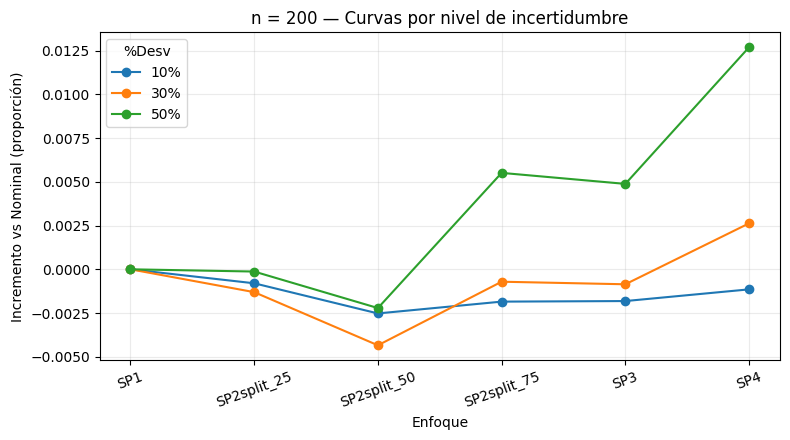

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Filtrado n=200 y preparación en formato largo
d = df_agg_incs[df_agg_incs["n"] == 50].copy()

enfoques = ["inc_SP1_pct","inc_SP3_pct","inc_SP4_pct",
            "inc_SP2split_25_pct","inc_SP2split_50_pct","inc_SP2split_75_pct"]

lab_map  = {"inc_SP1_pct":"SP1","inc_SP3_pct":"SP3","inc_SP4_pct":"SP4",
            "inc_SP2split_25_pct":"SP2split_25",
            "inc_SP2split_50_pct":"SP2split_50",
            "inc_SP2split_75_pct":"SP2split_75"}

rows = []
for _, r in d.iterrows():
    for e in enfoques:
        rows.append({
            "%Desv": r["%Desv"],
            "enfoque": lab_map[e],
            "mean": r.get(f"{e}_mean", np.nan),
            "std":  r.get(f"{e}_std",  np.nan),
        })

plot_df = pd.DataFrame(rows)

# Orden del eje X
order = ["SP1","SP2split_25","SP2split_50","SP2split_75","SP3","SP4"]
plot_df["enfoque"] = pd.Categorical(plot_df["enfoque"], categories=order, ordered=True)
plot_df = plot_df.sort_values(["%Desv","enfoque"])

# 2) (Opcional) pasar a % para lectura
TO_PERCENT = False
if TO_PERCENT:
    plot_df[["mean","std"]] = plot_df[["mean","std"]]*100

# 3) Gráfico de líneas (una por cada %Desv)
fig, ax = plt.subplots(figsize=(8,4.5))
x = np.arange(len(order))

for desv in sorted(plot_df["%Desv"].unique()):
    df_ = plot_df[plot_df["%Desv"]==desv]
    y   = df_["mean"].to_numpy()
    ysd = df_["std"].to_numpy()
    ax.plot(x, y, marker="o", label=f"{int(round(desv*100))}%")
    # Banda de ±1 std (descomenta si la quieres)
    # ax.fill_between(x, y-ysd, y+ysd, alpha=0.15)

ax.set_xticks(x); ax.set_xticklabels(order, rotation=20)
ax.set_xlabel("Enfoque")
ax.set_ylabel("Incremento vs Nominal" + (" (%)" if TO_PERCENT else " (proporción)"))
ax.set_title("n = 200 — Curvas por nivel de incertidumbre")
ax.grid(True, which="both", alpha=0.25)
ax.legend(title="%Desv")
plt.tight_layout()
plt.show()


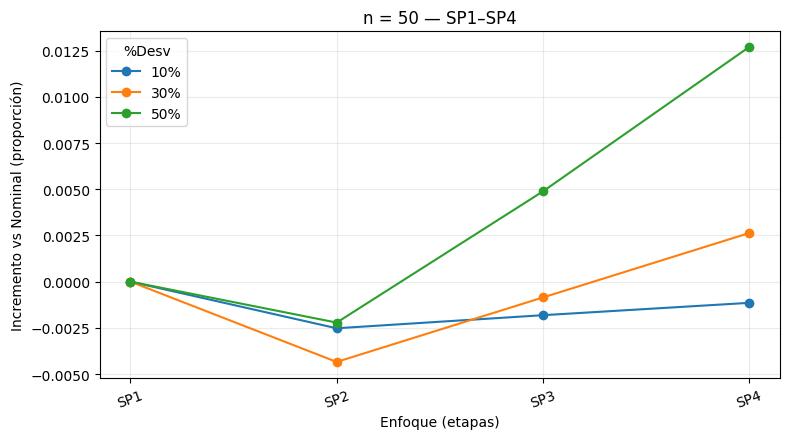

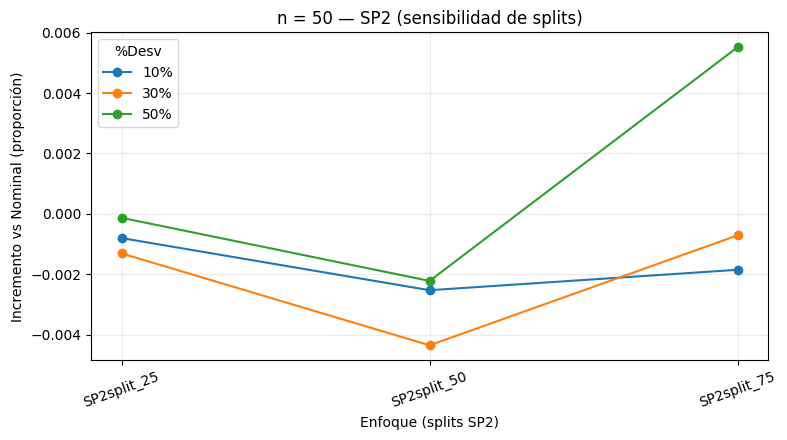

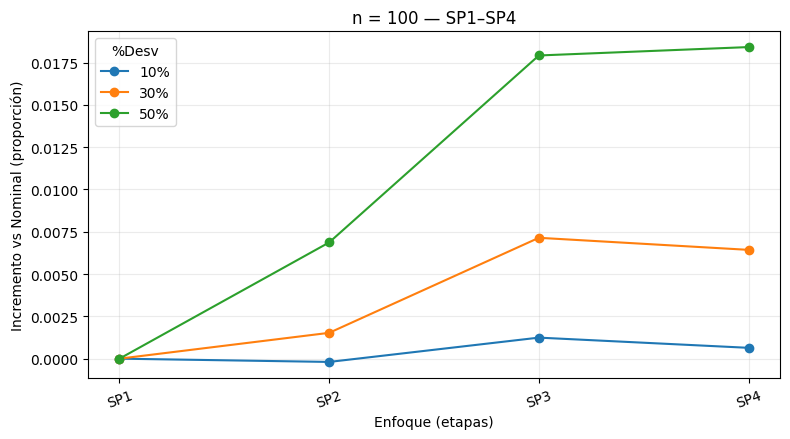

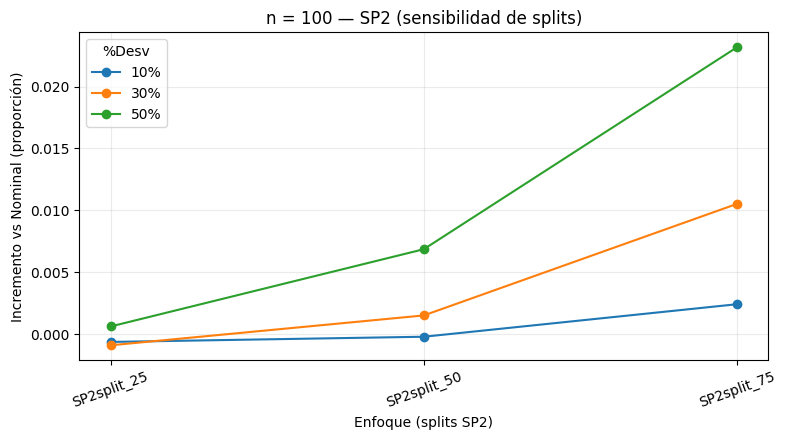

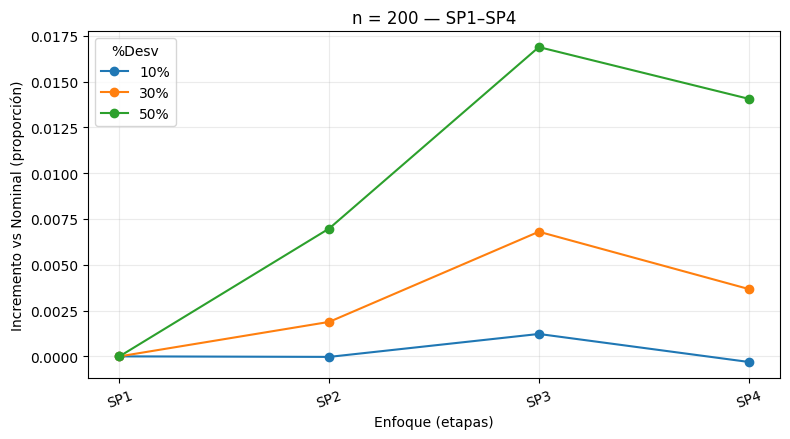

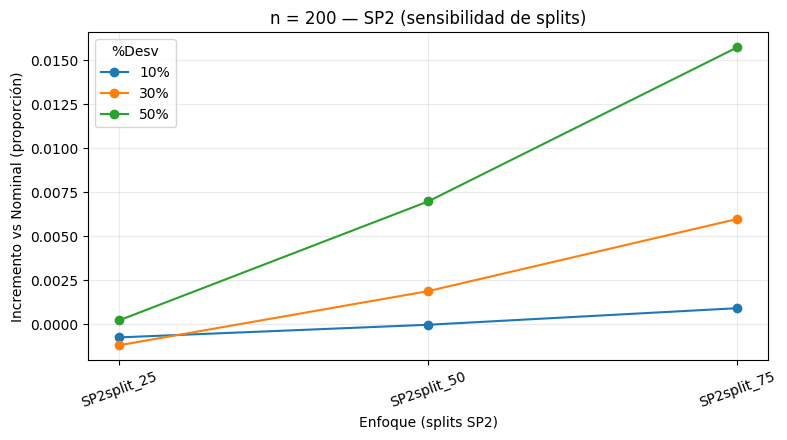

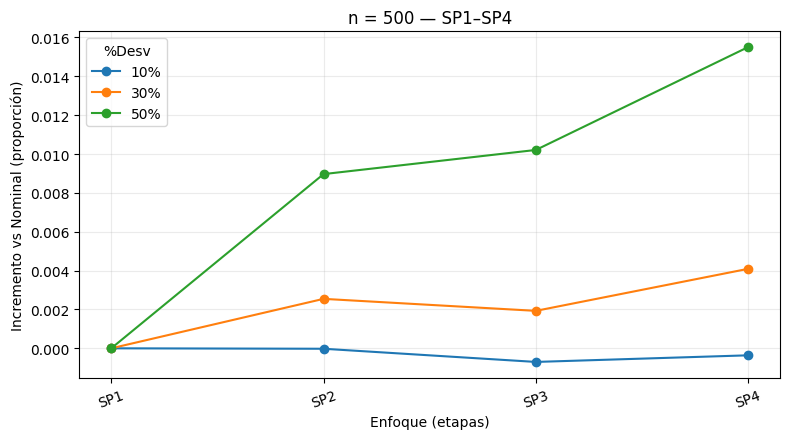

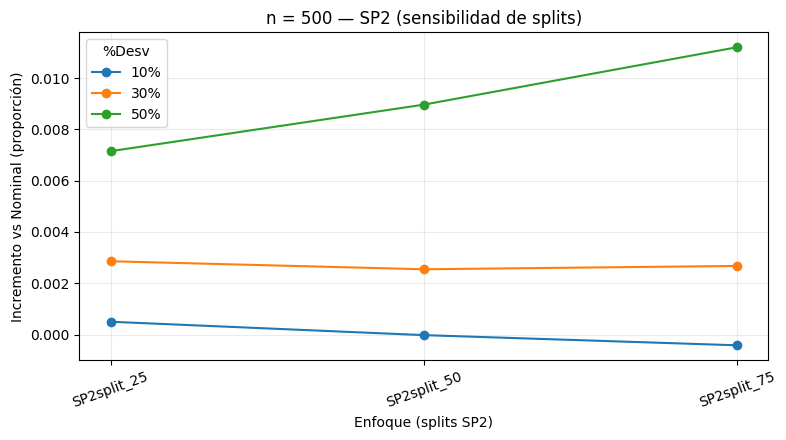

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# =================================
# Configuración
# =================================
TO_PERCENT = False       # si True, pasa los incrementos a %
SHOW_STD_BAND = False    # si True, muestra banda ±1 std

# Helper: pasar a formato largo
def to_long(df_agg_incs, n_fixed, enfoques, lab_map):
    d = df_agg_incs[df_agg_incs["n"] == n_fixed].copy()
    rows = []
    for _, r in d.iterrows():
        for e in enfoques:
            rows.append({
                "%Desv": r["%Desv"],
                "enfoque": lab_map[e],
                "mean": r.get(f"{e}_mean", np.nan),
                "std":  r.get(f"{e}_std",  np.nan),
            })
    out = pd.DataFrame(rows)
    if TO_PERCENT:
        out[["mean","std"]] = out[["mean","std"]]*100
    return out

# Definición de enfoques
enfoques_A = ["inc_SP1_pct","inc_SP2_pct","inc_SP3_pct","inc_SP4_pct"]
lab_map_A  = {"inc_SP1_pct":"SP1","inc_SP2_pct":"SP2","inc_SP3_pct":"SP3","inc_SP4_pct":"SP4"}
order_A    = ["SP1","SP2","SP3","SP4"]

enfoques_B = ["inc_SP2split_25_pct","inc_SP2split_50_pct","inc_SP2split_75_pct"]
lab_map_B  = {"inc_SP2split_25_pct":"SP2split_25",
              "inc_SP2split_50_pct":"SP2split_50",
              "inc_SP2split_75_pct":"SP2split_75"}
order_B    = ["SP2split_25","SP2split_50","SP2split_75"]

# Lista de n disponibles
ns = sorted(df_agg_incs["n"].dropna().unique().tolist())

for N_VAL in ns:
    # =========================
    # Figura A: SP1–SP4
    # =========================
    plot_A = to_long(df_agg_incs, N_VAL, enfoques_A, lab_map_A)
    plot_A["enfoque"] = pd.Categorical(plot_A["enfoque"], categories=order_A, ordered=True)
    plot_A = plot_A.sort_values(["%Desv","enfoque"])
    levels = sorted(plot_A["%Desv"].dropna().unique().tolist())

    fig, ax = plt.subplots(figsize=(8,4.5))
    xA = np.arange(len(order_A))

    for desv in levels:
        df_ = plot_A[plot_A["%Desv"]==desv]
        y   = df_.sort_values("enfoque")["mean"].to_numpy()
        ysd = df_.sort_values("enfoque")["std"].to_numpy()
        ax.plot(xA, y, marker="o", label=f"{int(round(desv*100))}%")
        if SHOW_STD_BAND:
            ax.fill_between(xA, y-ysd, y+ysd, alpha=0.15)

    ax.set_xticks(xA); ax.set_xticklabels(order_A, rotation=20)
    ax.set_xlabel("Enfoque (etapas)")
    ax.set_ylabel("Incremento vs Nominal" + (" (%)" if TO_PERCENT else " (proporción)"))
    ax.set_title(f"n = {N_VAL} — SP1–SP4")
    ax.grid(True, which="both", alpha=0.25)
    ax.legend(title="%Desv")
    plt.tight_layout()
    plt.show()

    # =========================
    # Figura B: SP2 splits
    # =========================
    plot_B = to_long(df_agg_incs, N_VAL, enfoques_B, lab_map_B)
    plot_B["enfoque"] = pd.Categorical(plot_B["enfoque"], categories=order_B, ordered=True)
    plot_B = plot_B.sort_values(["%Desv","enfoque"])

    fig, ax = plt.subplots(figsize=(8,4.5))
    xB = np.arange(len(order_B))

    for desv in levels:
        df_ = plot_B[plot_B["%Desv"]==desv]
        y   = df_.sort_values("enfoque")["mean"].to_numpy()
        ysd = df_.sort_values("enfoque")["std"].to_numpy()
        ax.plot(xB, y, marker="o", label=f"{int(round(desv*100))}%")
        if SHOW_STD_BAND:
            ax.fill_between(xB, y-ysd, y+ysd, alpha=0.15)

    ax.set_xticks(xB); ax.set_xticklabels(order_B, rotation=20)
    ax.set_xlabel("Enfoque (splits SP2)")
    ax.set_ylabel("Incremento vs Nominal" + (" (%)" if TO_PERCENT else " (proporción)"))
    ax.set_title(f"n = {N_VAL} — SP2 (sensibilidad de splits)")
    ax.grid(True, which="both", alpha=0.25)
    ax.legend(title="%Desv")
    plt.tight_layout()
    plt.show()


Usando %Desv = 0.3 (30%)


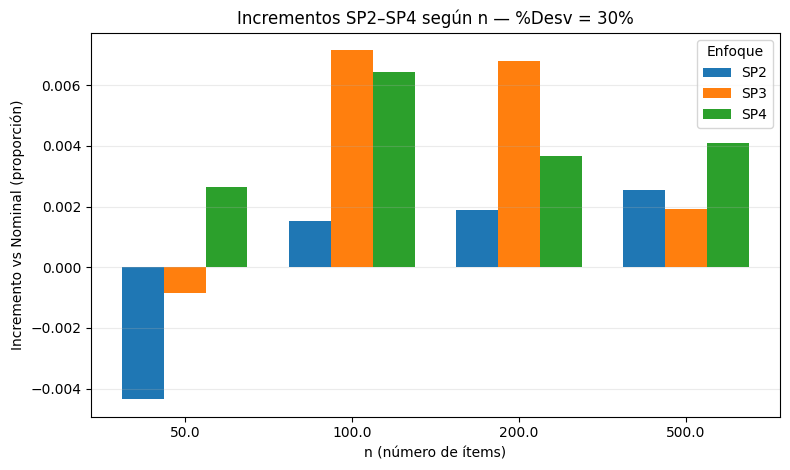

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# ================================
# Configuración
# ================================
TO_PERCENT = False       # si True, convierte a %
SHOW_STD_BAND = False    # si True, añade barra de error con la std
DESV_LEVEL = None        # fija nivel de incertidumbre (ej: 0.30). Si None, usa el central.

# ================================
# Selección del nivel de incertidumbre
# ================================
levels = sorted(df_agg_incs["%Desv"].dropna().unique().tolist())
if DESV_LEVEL is None:
    DESV_LEVEL = levels[len(levels)//2]  # valor central
elif DESV_LEVEL not in levels:
    DESV_LEVEL = min(levels, key=lambda v: abs(v - DESV_LEVEL))

print(f"Usando %Desv = {DESV_LEVEL} ({int(DESV_LEVEL*100)}%)")

# ================================
# Preparación de datos (SP2, SP3, SP4)
# ================================
d = df_agg_incs[df_agg_incs["%Desv"] == DESV_LEVEL].copy()
enfoques = ["inc_SP2_pct","inc_SP3_pct","inc_SP4_pct"]
lab_map  = {"inc_SP2_pct":"SP2","inc_SP3_pct":"SP3","inc_SP4_pct":"SP4"}

rows = []
for _, r in d.iterrows():
    for e in enfoques:
        rows.append({
            "n": r["n"],
            "enfoque": lab_map[e],
            "mean": r.get(f"{e}_mean", np.nan),
            "std":  r.get(f"{e}_std",  np.nan),
        })

plot_df = pd.DataFrame(rows)
if TO_PERCENT:
    plot_df[["mean","std"]] = plot_df[["mean","std"]]*100

# ================================
# Gráfico de barras agrupadas
# ================================
ns = sorted(plot_df["n"].unique())
enfoques_plot = ["SP2","SP3","SP4"]
bar_width = 0.25
x = np.arange(len(ns))

fig, ax = plt.subplots(figsize=(8,4.8))

for i, enf in enumerate(enfoques_plot):
    df_e = plot_df[plot_df["enfoque"]==enf].sort_values("n")
    vals = df_e["mean"].to_numpy()
    errs = df_e["std"].to_numpy() if SHOW_STD_BAND else None
    ax.bar(x + i*bar_width, vals, width=bar_width, label=enf, yerr=errs, capsize=4)

ax.set_xticks(x + bar_width)
ax.set_xticklabels(ns)
ax.set_xlabel("n (número de ítems)")
ax.set_ylabel("Incremento vs Nominal" + (" (%)" if TO_PERCENT else " (proporción)"))
ax.set_title(f"Incrementos SP2–SP4 según n — %Desv = {int(DESV_LEVEL*100)}%")
ax.legend(title="Enfoque")
ax.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


Usando %Desv = 0.3 (30%)


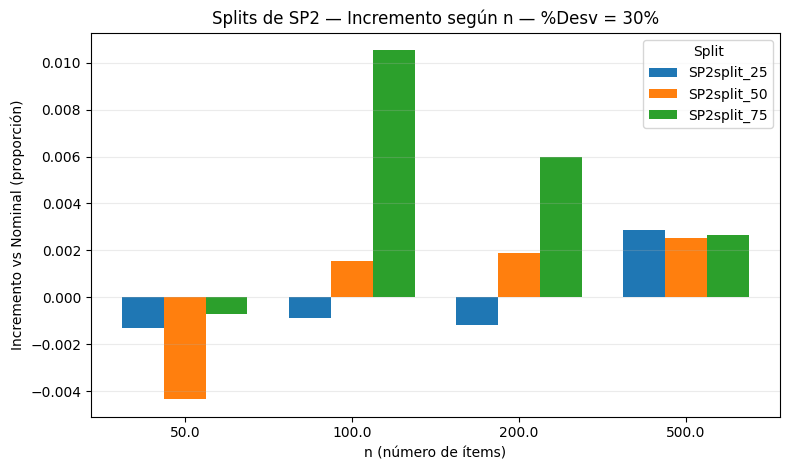

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# ================================
# Configuración
# ================================
TO_PERCENT = False       # si True, convierte a %
SHOW_STD_BAND = False    # si True, añade barras de error con la std
DESV_LEVEL = None        # fija nivel de incertidumbre (ej: 0.30). Si None, usa el central.

# ================================
# Selección del nivel de incertidumbre
# ================================
levels = sorted(df_agg_incs["%Desv"].dropna().unique().tolist())
if DESV_LEVEL is None:
    DESV_LEVEL = levels[len(levels)//2]  # valor central
elif DESV_LEVEL not in levels:
    DESV_LEVEL = min(levels, key=lambda v: abs(v - DESV_LEVEL))

print(f"Usando %Desv = {DESV_LEVEL} ({int(DESV_LEVEL*100)}%)")

# ================================
# Preparación de datos (SP2 splits)
# ================================
d = df_agg_incs[df_agg_incs["%Desv"] == DESV_LEVEL].copy()
enfoques = ["inc_SP2split_25_pct","inc_SP2split_50_pct","inc_SP2split_75_pct"]
lab_map  = {"inc_SP2split_25_pct":"SP2split_25",
            "inc_SP2split_50_pct":"SP2split_50",
            "inc_SP2split_75_pct":"SP2split_75"}

rows = []
for _, r in d.iterrows():
    for e in enfoques:
        rows.append({
            "n": r["n"],
            "enfoque": lab_map[e],
            "mean": r.get(f"{e}_mean", np.nan),
            "std":  r.get(f"{e}_std",  np.nan),
        })

plot_df = pd.DataFrame(rows)
if TO_PERCENT:
    plot_df[["mean","std"]] = plot_df[["mean","std"]]*100

# ================================
# Gráfico de barras agrupadas (splits)
# ================================
ns = sorted(plot_df["n"].unique())
enfoques_plot = ["SP2split_25","SP2split_50","SP2split_75"]
bar_width = 0.25
x = np.arange(len(ns))

fig, ax = plt.subplots(figsize=(8,4.8))

for i, enf in enumerate(enfoques_plot):
    df_e = plot_df[plot_df["enfoque"]==enf].sort_values("n")
    vals = df_e["mean"].to_numpy()
    errs = df_e["std"].to_numpy() if SHOW_STD_BAND else None
    ax.bar(x + i*bar_width, vals, width=bar_width, label=enf, yerr=errs, capsize=4)

ax.set_xticks(x + bar_width)
ax.set_xticklabels(ns)
ax.set_xlabel("n (número de ítems)")
ax.set_ylabel("Incremento vs Nominal" + (" (%)" if TO_PERCENT else " (proporción)"))
ax.set_title(f"Splits de SP2 — Incremento según n — %Desv = {int(DESV_LEVEL*100)}%")
ax.legend(title="Split")
ax.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


In [22]:
df_experimento_agg.columns

Index(['n', '%Desv', 'Nominal_mean', 'Nominal_std', 'SP1_mean', 'SP1_std',
       'SP2_mean', 'SP2_std', 'SP3_mean', 'SP3_std', 'SP4_mean', 'SP4_std',
       'SP2split_25_mean', 'SP2split_25_std', 'SP2split_50_mean',
       'SP2split_50_std', 'SP2split_75_mean', 'SP2split_75_std',
       'inc_SP1_pct_mean', 'inc_SP1_pct_std', 'inc_SP2_pct_mean',
       'inc_SP2_pct_std', 'inc_SP3_pct_mean', 'inc_SP3_pct_std',
       'inc_SP4_pct_mean', 'inc_SP4_pct_std', 'inc_SP2split_25_pct_mean',
       'inc_SP2split_25_pct_std', 'inc_SP2split_50_pct_mean',
       'inc_SP2split_50_pct_std', 'inc_SP2split_75_pct_mean',
       'inc_SP2split_75_pct_std', 'inc_SP2split_25_vs_SP_pct_mean',
       'inc_SP2split_25_vs_SP_pct_std', 'inc_SP2split_50_vs_SP_pct_mean',
       'inc_SP2split_50_vs_SP_pct_std', 'inc_SP2split_75_vs_SP_pct_mean',
       'inc_SP2split_75_vs_SP_pct_std'],
      dtype='object')

In [4]:
from google.colab import files
uploaded = files.upload()


Saving SP - Resultados Experimentos Computacionales.xlsx to SP - Resultados Experimentos Computacionales.xlsx


In [7]:
import pandas as pd
df = pd.read_excel("SP - Resultados Experimentos Computacionales.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   n       36 non-null     int64  
 1   %Desv   36 non-null     float64
 2   split   36 non-null     object 
 3   SP1     36 non-null     float64
 4   SP2     36 non-null     float64
 5   SP3     36 non-null     float64
 6   SP4     36 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 2.1+ KB


In [10]:
display(df)

,n,%Desv,split,SP1,SP2,SP3,SP4
0,50,0.1,0.00-0.50-0.25-0.25,-0.224568,-0.151307,-0.122223,-0.114725
1,50,0.1,0.10-0.30-0.30-0.30,-0.179919,-0.136159,-0.100670,-0.087307
2,50,0.1,0.25-0.25-0.25-0.25,-0.321435,-0.294593,-0.273170,-0.261746
3,50,0.3,0.00-0.50-0.25-0.25,-0.529281,-0.017582,0.183112,0.262910
4,50,0.3,0.10-0.30-0.30-0.30,-0.435057,-0.115768,0.207533,0.348677
5,50,0.3,0.25-0.25-0.25-0.25,-0.858163,-0.659100,-0.454281,-0.331370
6,50,0.5,0.00-0.50-0.25-0.25,-0.703740,0.510720,1.015294,1.270137
7,50,0.5,0.10-0.30-0.30-0.30,-0.580855,0.180771,0.939430,1.336965
8,50,0.5,0.25-0.25-0.25-0.25,-1.266105,-0.740680,-0.254914,0.092009
9,100,0.1,0.00-0.50-0.25-0.25,0.017522,0.045925,0.055451,0.064022


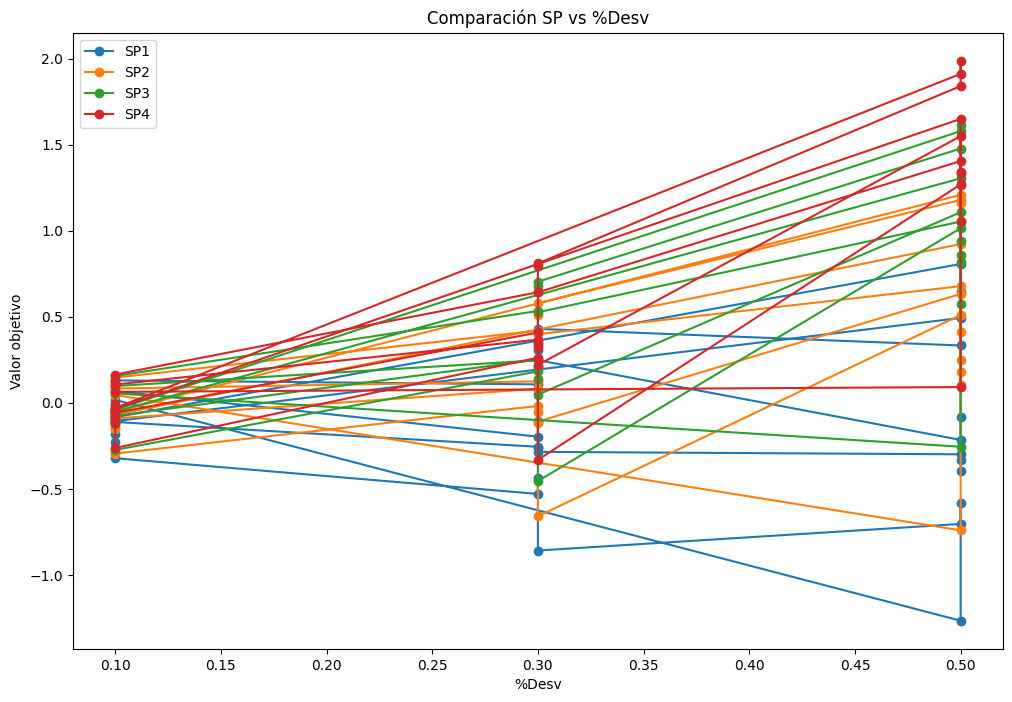

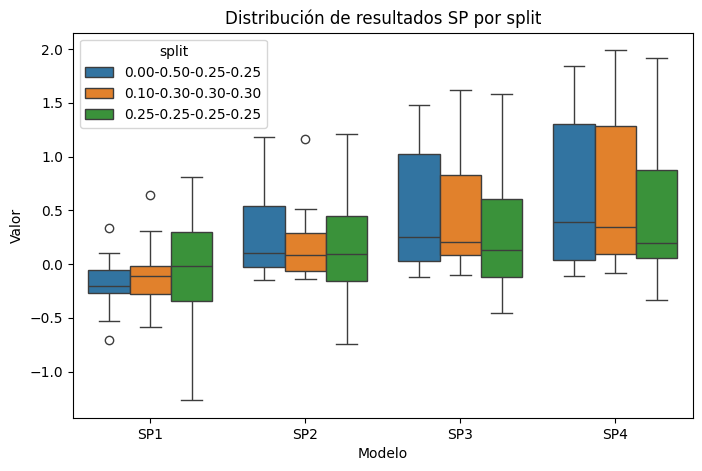

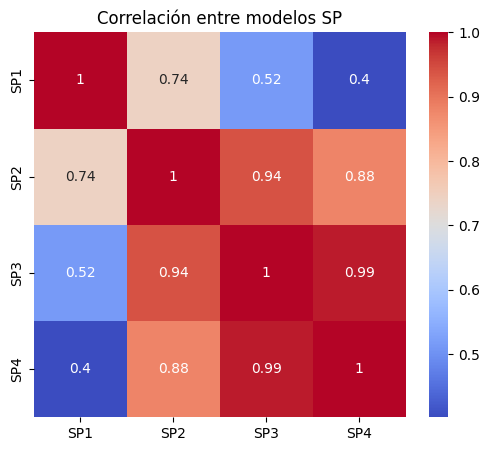

/tmp/ipython-input-1834403058.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melt, x="Modelo", y="Valor", hue="split", ci=None)


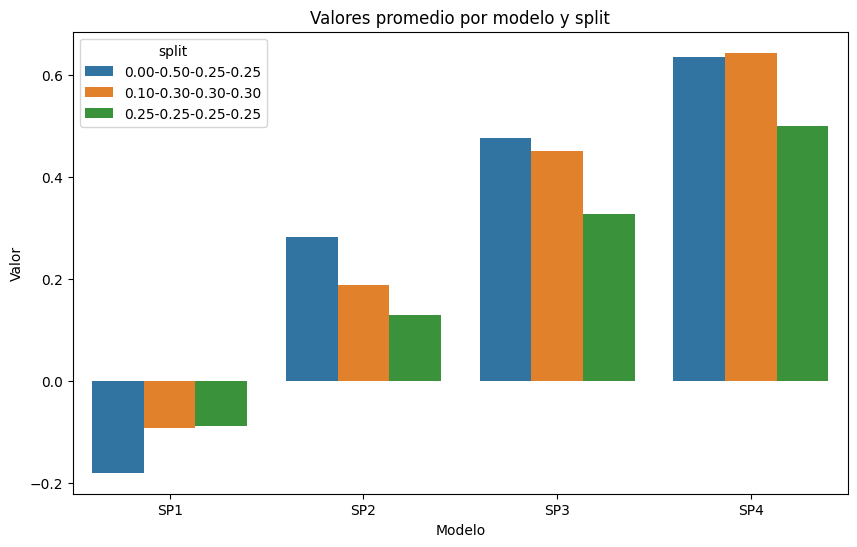

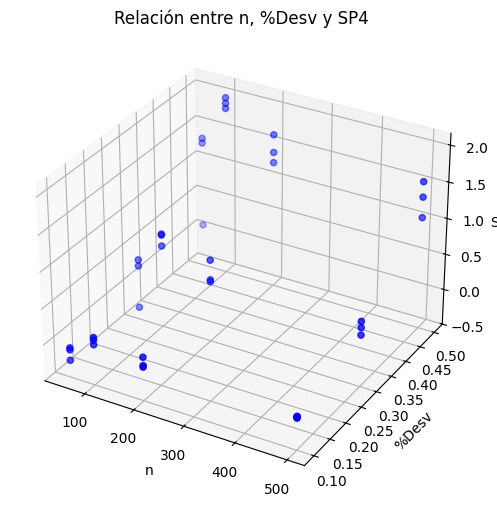

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Evolución de los enfoques SP con %Desv (líneas)
plt.figure(figsize=(12,8))
for col in ["SP1","SP2","SP3","SP4"]:
    plt.plot(df["%Desv"], df[col], marker="o", label=col)
plt.xlabel("%Desv")
plt.ylabel("Valor objetivo")
plt.title("Comparación SP vs %Desv")
plt.legend()
plt.show()

# 2. Boxplots por split (ver dispersión de resultados SP)
plt.figure(figsize=(8,5))
df_melt = df.melt(id_vars=["split"], value_vars=["SP1","SP2","SP3","SP4"],
                  var_name="Modelo", value_name="Valor")
sns.boxplot(data=df_melt, x="Modelo", y="Valor", hue="split")
plt.title("Distribución de resultados SP por split")
plt.show()

# 3. Heatmap correlaciones entre SP1–SP4
plt.figure(figsize=(6,5))
sns.heatmap(df[["SP1","SP2","SP3","SP4"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlación entre modelos SP")
plt.show()

# 4. Barras agrupadas: comparar SP por split
plt.figure(figsize=(10,6))
sns.barplot(data=df_melt, x="Modelo", y="Valor", hue="split", ci=None)
plt.title("Valores promedio por modelo y split")
plt.show()

# 5. Gráfica 3D: (n, %Desv, SP4)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df["n"], df["%Desv"], df["SP4"], c="blue", marker="o")
ax.set_xlabel("n")
ax.set_ylabel("%Desv")
ax.set_zlabel("SP4")
plt.title("Relación entre n, %Desv y SP4")
plt.show()


## bertsimas model

In [ ]:
# ================== Bertsimas–Sim (fraccional) con MIP + Excel (XlsxWriter) ==================
import sys, subprocess, time
import numpy as np
import pandas as pd
from mip import Model, CONTINUOUS, MAXIMIZE, CBC, OptimizationStatus

def solve_nominal_fractional_mip(c_bar, pesos, capacidad, time_limit=3600, solver_name=CBC):
    """Max sum c_bar x  s.a. sum w x <= cap, 0<=x<=1 (fraccional) con MIP."""
    c_bar = np.asarray(c_bar, float)
    pesos = np.asarray(pesos, float)
    n = c_bar.size

    m = Model(sense=MAXIMIZE, solver_name=solver_name)
    m.max_seconds = time_limit
    x = [m.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x_{j}") for j in range(n)]

    m.objective = sum(c_bar[j]*x[j] for j in range(n))
    m += (sum(pesos[j]*x[j] for j in range(n)) <= capacidad), "cap"

    t0 = time.perf_counter(); status = m.optimize(); t1 = time.perf_counter()
    obj = m.objective_value if status in (OptimizationStatus.OPTIMAL, OptimizationStatus.FEASIBLE) else np.nan
    return float(obj), status, t1-t0


def solve_knapsack_bs_mip(c_bar, c_hat, pesos, capacidad, gamma, time_limit=3600, solver_name=CBC):
    """
    Bertsimas–Sim robusto (fraccional, x in [0,1]) con MIP (CBC):
      max  sum c_bar_j x_j  - gamma*z  - sum p_j
      s.a. d_j x_j - z - p_j <= 0  (∀j)
           sum w_j x_j <= capacidad
           x ∈ [0,1], z>=0, p>=0
    Devuelve además eval_cx = sum c_bar_j x_j (evaluación nominal de la solución x*).
    """
    c_bar = np.asarray(c_bar, float)
    c_hat = np.asarray(c_hat, float)
    pesos = np.asarray(pesos, float)
    n = c_bar.size
    assert c_hat.size == n and pesos.size == n, "Dimensiones incoherentes"

    m = Model(sense=MAXIMIZE, solver_name=solver_name)
    m.max_seconds = time_limit

    # Variables
    x = [m.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x_{j}") for j in range(n)]
    z = m.add_var(var_type=CONTINUOUS, lb=0.0, name="z")
    p = [m.add_var(var_type=CONTINUOUS, lb=0.0, name=f"p_{j}") for j in range(n)]

    # Objetivo robusto
    m.objective = sum(c_bar[j]*x[j] for j in range(n)) - gamma*z - sum(p[j] for j in range(n))

    # Capacidad
    m += (sum(pesos[j]*x[j] for j in range(n)) <= capacidad), "cap"

    # Robustez: d_j x_j - z - p_j <= 0
    for j in range(n):
        m += (c_hat[j]*x[j] - z - p[j] <= 0), f"rob_{j}"

    t0 = time.perf_counter()
    status = m.optimize()
    t1 = time.perf_counter()
    ok = status in (OptimizationStatus.OPTIMAL, OptimizationStatus.FEASIBLE)
    obj = float(m.objective_value) if ok else np.nan

    # Extra: evaluación nominal de la solución x* (sin penalizaciones)
    if ok:
        sol_x = np.array([var.x for var in x], dtype=float)
        eval_cx = float(np.dot(c_bar, sol_x))
        sol_z = float(z.x)
        sol_p = np.array([var.x for var in p], dtype=float)
    else:
        sol_x = None
        eval_cx = np.nan
        sol_z = np.nan
        sol_p = None

    return {
        "ok": ok,
        "status": str(status),
        "objective": obj,         # robusto: c·x - gamma z - sum p
        "eval_cx": eval_cx,       # nominal: c·x
        "x": sol_x,
        "z": sol_z,
        "p": sol_p,
        "time_s": round(t1 - t0, 6),
        "n_vars": m.num_cols,
        "n_constrs": m.num_rows,
        "model": m,
    }


def total_solver_bs_mip(
    df_kplib,
    pct_desviacion_list=(0.10, 0.30, 0.50),
    gamma_pcts=(0.00, 0.05, 0.10, 0.25, 0.50, 0.75, 1.00),
    sizes=(50, 100, 200, 500),
    k=20,
    time_limit=3600,
    check_nominal=True,
):
    filas = []

    for pct_desviacion in pct_desviacion_list:
        for n_target in sizes:
            df_sub = df_kplib[df_kplib["n"] == n_target].head(k)
            print(f"\n=== n = {n_target} | {len(df_sub)} instancias | pct_desv={pct_desviacion} ===")
            for idx, row in df_sub.iterrows():
                cbar = np.array(row["Utilidades"], float)
                w    = np.array(row["Pesos"], float)
                cap  = float(row["Capacidad"])
                arc  = row["Archivo"] if "Archivo" in df_kplib.columns else f"idx_{idx}"
                n    = cbar.size
                assert w.size == n, f"Dim mismatch en {arc}"

                # d_j = pct * |c̄_j|
                chat = np.abs(pct_desviacion * cbar)

                # Chequeo nominal (Γ=0) vs LP nominal fraccional (con MIP también)
                if check_nominal:
                    f_nom, st_nom, _ = solve_nominal_fractional_mip(cbar, w, cap, time_limit=time_limit)
                else:
                    f_nom = np.nan

                for pct in gamma_pcts:
                    gamma = int(round(pct * n))
                    sol = solve_knapsack_bs_mip(cbar, chat, w, cap, gamma, time_limit=time_limit)

                    if sol["ok"]:
                        if check_nominal and gamma == 0 and np.isfinite(f_nom):
                            diff = abs(sol["objective"] - f_nom)
                            if diff > 1e-6:
                                print(f"[Aviso] {arc} | Γ=0: nominal={f_nom:.6f}, robust={sol['objective']:.6f} (ambos fraccionales)")

                        filas.append({
                            "Archivo": arc,
                            "n": int(row["n"]),
                            "Capacidad": cap,
                            "%Desv": pct_desviacion,
                            "Gamma": gamma,
                            "%Gamma": pct,
                            "Valor objetivo": sol["objective"],   # robusto
                            "Eval c·x": sol["eval_cx"],            # nominal de la solución
                            "z": sol["z"],
                            "Tiempo (s)": sol["time_s"],
                            "Status": sol["status"],
                            "n_vars": sol["n_vars"],
                            "n_constrs": sol["n_constrs"],
                        })
                    else:
                        print(f"  {arc} | Γ={gamma}: fallo -> {sol['status']}")

    # ---- DataFrame largo ----
    df_long = pd.DataFrame(filas)
    if not df_long.empty:
        df_long[["Valor objetivo", "Eval c·x", "z", "Tiempo (s)"]] = df_long[["Valor objetivo", "Eval c·x", "z", "Tiempo (s)"]].round(6)

    print("\n=== Resumen (primeras filas) ===")
    print(df_long.head(10))
    # ---- Tabla wide: objetivos, evaluación c·x y tiempos por Γ ----
    keys = ["Archivo", "n", "Capacidad", "%Desv"]

    def rename_cols(df, prefix):
        ren = {}
        for col in df.columns:
            if isinstance(col, float):  # columnas de %Gamma
                ren[col] = f"{prefix}_Gamma{int(round(col*100))}%"
        return df.rename(columns=ren)

    # f(Γ)
    wide_obj = (
        df_long.pivot(index=keys, columns="%Gamma", values="Valor objetivo")
              .sort_index(axis=1)
              .reset_index()
    )
    wide_obj = rename_cols(wide_obj, "f")

    # c·x(Γ)
    wide_cx = (
        df_long.pivot(index=keys, columns="%Gamma", values="Eval c·x")
              .sort_index(axis=1)
              .reset_index()
    )
    wide_cx = rename_cols(wide_cx, "cx")

    # t(Γ)
    wide_time = (
        df_long.pivot(index=keys, columns="%Gamma", values="Tiempo (s)")
              .sort_index(axis=1)
              .reset_index()
    )
    wide_time = rename_cols(wide_time, "tiempo")

    # Unimos
    df_wide = wide_obj.merge(wide_cx, on=keys, how="inner").merge(wide_time, on=keys, how="inner")

    # print("\n=== Wide (primeras filas) ===")
    # print(df_wide.head(10))

    # # ---- Guardar Excel con XlsxWriter ----
    # out_name = "BertsimasSim_MIP.xlsx"
    # with pd.ExcelWriter(out_name, engine=EXCEL_ENGINE) as writer:
    #     df_long.to_excel(writer, sheet_name="long", index=False)
    #     df_wide.to_excel(writer, sheet_name="wide", index=False)

    # if IN_COLAB:
    #     files.download(out_name)
    # else:
    #     print(f"[Info] Archivo guardado: {out_name}")

    return df_long, df_wide, wide_time, wide_obj, wide_cx


# ================== EJECUCIÓN (ejemplo) ==================
long_bs, wide_bs, wide_time_bs, wide_obj_bs, wide_cx_bs = total_solver_bs_mip(
    df_kplib,
    pct_desviacion_list=(0.10, 0.30, 0.50),
    gamma_pcts=(0.00, 0.05, 0.10, 0.25, 0.50, 0.75, 1.00),
    sizes=(50, 100, 200, 500),
    k=20,
    time_limit=3600,
    check_nominal=True,
)




In [ ]:
wide_obj_bs.to_excel("wide_obj_bs.xlsx")
wide_time_bs.to_excel("wide_time_bs.xlsx")
wide_bs.to_excel("wide_bs.xlsx")
files.download("wide_obj_bs.xlsx")
files.download("wide_time_bs.xlsx")
files.download("wide_bs.xlsx")

# estudio valor objetivo

In [ ]:
wide_obj_bs.info()
wide_obj_sp.info()

import numpy as np
import pandas as pd

# ========= 1) Unir ambos wide (objetivo) por claves =========
keys = ["Archivo", "n", "Capacidad", "%Desv"]
wide_obj = wide_obj_bs.merge(wide_obj_sp, on=keys, how="inner")

# ========= 2) Seleccionar columnas de objetivo y pasar a largo =========
cols_sp_obj = ["SP1", "SP2", "SP3", "SP4"]
cols_bs_obj = [c for c in wide_obj.columns if c.startswith("f_Gamma")]
cols_obj = cols_sp_obj + cols_bs_obj

long_obj = wide_obj.melt(
    id_vars=["Archivo", "n", "%Desv"],
    value_vars=cols_obj,
    var_name="Metodo",
    value_name="Valor"
)

# Normalizamos nombres de métodos Gamma (opcional estético)
long_obj["Metodo"] = long_obj["Metodo"].str.replace("^f_", "", regex=True)  # f_GammaX% -> GammaX%

# ========= 3) Promedio sobre %Desv por (Archivo, n, Metodo) =========
long_obj_avg = (
    long_obj
    .groupby(["Archivo", "n", "Metodo"], as_index=False)["Valor"]
    .mean()
)

# ========= 4) Estadísticos por (n, Metodo) =========
df_stats_obj = (
    long_obj_avg
    .groupby(["n", "Metodo"])["Valor"]
    .agg(
        Mediana="median",
        Q1=lambda x: np.percentile(x, 25),
        Q3=lambda x: np.percentile(x, 75),
        Media="mean",
        **{"Desv. típica": "std"}
    )
    .reset_index()
)

# ========= 5) Funciones auxiliares de tablas (igual que en tiempos) =========
def tabla_mediana(df, escala=1.0, dec=4, con_intervalo=False):
    df2 = df.copy()
    if con_intervalo:
        df2["Mediana [Q1, Q3]"] = df2.apply(
            lambda r: f"{r['Mediana']*escala:.{dec}f} [{r['Q1']*escala:.{dec}f}, {r['Q3']*escala:.{dec}f}]",
            axis=1
        )
        out = df2.pivot(index="n", columns="Metodo", values="Mediana [Q1, Q3]").reset_index()
    else:
        df2["Mediana"] = (df2["Mediana"]*escala).round(dec)
        out = df2.pivot(index="n", columns="Metodo", values="Mediana").reset_index()
    return out

def tabla_media(df, escala=1.0, dec=4, con_desv=False):
    df2 = df.copy()
    if con_desv:
        df2["Media ± Desv. típica"] = df2.apply(
            lambda r: f"{r['Media']*escala:.{dec}f} ± {r['Desv. típica']*escala:.{dec}f}",
            axis=1
        )
        out = df2.pivot(index="n", columns="Metodo", values="Media ± Desv. típica").reset_index()
    else:
        df2["Media"] = (df2["Media"]*escala).round(dec)
        out = df2.pivot(index="n", columns="Metodo", values="Media").reset_index()
    return out

# ========= 6) Generar tablas (sin escalado; ajusta escala/decimales si lo necesitas) =========
# (a) Mediana sola
tabla_obj_mediana = tabla_mediana(df_stats_obj, escala=1.0, dec=4, con_intervalo=False)

# (b) Media sola
tabla_obj_media = tabla_media(df_stats_obj, escala=1.0, dec=4, con_desv=False)

# (c) Mediana [Q1,Q3]
tabla_obj_mediana_iqr = tabla_mediana(df_stats_obj, escala=1.0, dec=4, con_intervalo=True)

# (d) Media ± Desv. típica
tabla_obj_media_desv = tabla_media(df_stats_obj, escala=1.0, dec=4, con_desv=True)

# ========= 7) (Opcional) ordenar columnas: SP1..SP4 y luego Gammas ascendentes =========
orden_cols = (["n"] + cols_sp_obj + sorted([c.replace("f_", "") for c in cols_bs_obj]))
for df_out in (tabla_obj_mediana, tabla_obj_media, tabla_obj_mediana_iqr, tabla_obj_media_desv):
    existing = [c for c in orden_cols if c in df_out.columns]
    df_out.sort_index(axis=1, inplace=True)  # orden alfabético por si acaso
    df_out = df_out.reindex(columns=(["n"] + [c for c in orden_cols[1:] if c in df_out.columns]))

display(tabla_obj_mediana)
display(tabla_obj_media)
display(tabla_obj_mediana_iqr)
display(tabla_obj_media_desv)


In [ ]:
import numpy as np
import pandas as pd

# Claves comunes
keys = ["Archivo", "n", "Capacidad", "%Desv"]

# Unimos objetivos SP y RO (Bertsimas–Sim)
wide_obj_all = wide_obj_bs.merge(wide_obj_sp, on=keys, how="inner")

# Columnas de métodos
cols_gamma = [c for c in wide_obj_all.columns if c.startswith("f_Gamma")]
cols_sp    = ["SP1", "SP2", "SP3", "SP4"]

# ========= 1) Incrementos % respecto a SP1 =========
baseline_sp = wide_obj_all["SP1"].astype(float)

# Métodos a comparar vs SP1: SP2..SP4 + todos los Gamma
cols_vs_sp = ["SP2", "SP3", "SP4"] + cols_gamma

def pct_inc(col_vals, base):
    col_vals = col_vals.astype(float)
    # Evitar división por 0: si base==0 -> NaN
    return np.where(base != 0.0, (col_vals - base) / base, np.nan)

wide_obj_vs_sp = wide_obj_all[keys].copy()
# SP1 como 0%
wide_obj_vs_sp["SP1"] = 0.0
# Resto respecto a SP1
for c in cols_vs_sp:
    wide_obj_vs_sp[c] = pct_inc(wide_obj_all[c], baseline_sp)

# (Opcional) orden de columnas
wide_obj_vs_sp = wide_obj_vs_sp[keys + cols_sp + cols_gamma]

# ========= 2) Incrementos % respecto a nominal (Gamma = 0%) =========
baseline_nom = wide_obj_all["f_Gamma0%"].astype(float)

# Métodos a comparar vs Γ=0%: SP1..SP4 + Gamma5..Gamma100 (dejamos Gamma0 como 0)
cols_vs_nom = cols_sp + [c for c in cols_gamma if c != "f_Gamma0%"]

wide_obj_vs_nom = wide_obj_all[keys].copy()
# Gamma0% como 0%
wide_obj_vs_nom["f_Gamma0%"] = 0.0
# Resto respecto a Gamma0%
for c in cols_vs_nom:
    wide_obj_vs_nom[c] = pct_inc(wide_obj_all[c], baseline_nom)

# (Opcional) orden de columnas: claves + SP + Gammas (Gamma0 primero)
wide_obj_vs_nom = wide_obj_vs_nom[keys + cols_sp + ["f_Gamma0%"] + [c for c in cols_gamma if c != "f_Gamma0%"]]

# (Opcional) redondeo
wide_obj_vs_sp  = wide_obj_vs_sp.round(6)
wide_obj_vs_nom = wide_obj_vs_nom.round(6)

# Vistas rápidas
print("=== Incrementos % respecto a SP1 ===")
display(wide_obj_vs_sp.head())
print("\n=== Incrementos % respecto a Γ=0% (nominal) ===")
display(wide_obj_vs_nom.head())


In [ ]:
wide_obj_vs_sp.to_excel("wide_obj_vs_sp.xlsx")
wide_obj_vs_nom.to_excel("wide_obj_vs_nom.xlsx")

files.download("wide_obj_vs_sp.xlsx")
files.download("wide_obj_vs_nom.xlsx")

In [ ]:
df_nom_agg = (
    wide_obj_vs_nom
    .groupby(["n"], as_index=False)      # Agrupa por n
    .mean(numeric_only=True)            # Calcula la media de TODAS las columnas numéricas
)
df_nom_agg.to_excel("df_nom_agg_SOLO_NUM_ITEMS.xlsx")
files.download("df_nom_agg_SOLO_NUM_ITEMS.xlsx")

In [ ]:
df_nom_agg_STD = (
    wide_obj_vs_nom
    .groupby(["n"], as_index=False)      # Agrupa por n
    .std(numeric_only=True)             # Calcula la desviación típica de TODAS las columnas numéricas
)

df_nom_agg_STD.to_excel("df_nom_agg_SOLO_NUM_ITEMS_STD.xlsx")
files.download("df_nom_agg_SOLO_NUM_ITEMS_STD.xlsx")

In [ ]:
df_agg_incertidumbre = (
    wide_obj_vs_nom
    .groupby(["n", "%Desv"], as_index=False)
    .mean(numeric_only=True)
)

df_agg_incertidumbre_STD = (
    wide_obj_vs_nom
    .groupby(["n", "%Desv"], as_index=False)
    .std(numeric_only=True)
)

df_agg_incertidumbre.to_excel("df_agg_incertidumbre.xlsx")
df_agg_incertidumbre_STD.to_excel("df_agg_incertidumbre_STD.xlsx")
files.download("df_agg_incertidumbre.xlsx")
files.download("df_agg_incertidumbre_STD.xlsx")

# estudio de tiempo de computación

In [27]:
import numpy as np
import pandas as pd


wide_time = wide_time_bs.merge(
    wide_time_sp, on=["Archivo", "n", "Capacidad", "%Desv"],
    how="inner"
)
# --- Paso 1: Unir los dataframes (ya lo tienes) ---
# wide_time = wide_time_bs.merge(wide_time_sp, on=["Archivo", "n", "Capacidad", "%Desv"], how="inner")

# --- Paso 2: Seleccionar columnas de tiempo (mantenemos Archivo, n, %Desv) ---
cols_sp = ["tiempo_SP1", "tiempo_SP2", "tiempo_SP3", "tiempo_SP4"]
cols_bs = [c for c in wide_time.columns if c.startswith("tiempo_Gamma")]
cols_tiempo = cols_sp + cols_bs
base = wide_time[["Archivo", "n", "%Desv"] + cols_tiempo].copy()

# --- Paso 3: Formato largo conservando Archivo, n y %Desv ---
long_time = base.melt(
    id_vars=["Archivo", "n", "%Desv"],
    value_vars=cols_tiempo,
    var_name="Metodo",
    value_name="Tiempo"
)

# --- Paso 4: Promedio sobre %Desv por (Archivo, n, Metodo) ---
# (si hay varias filas para el mismo Archivo y n con %Desv=0.10/0.30/0.50, se promedia)
long_time_avg = (
    long_time
    .groupby(["Archivo", "n", "Metodo"], as_index=False)["Tiempo"]
    .mean()
)

# --- Paso 5: Estadísticos por (n, Metodo) usando las observaciones (Archivo) agregadas ---
def resumen(serie):
    med = serie.median()
    q1, q3 = np.percentile(serie, [25, 75])
    iqr = q3 - q1
    mean = serie.mean()
    std = serie.std(ddof=1)
    return pd.Series({
        "Median": med,
        "Median - IQR/2": med - iqr/2,
        "Median + IQR/2": med + iqr/2,
        "Mean": mean,
        "Mean - Std/2": mean - (std/2 if np.isfinite(std) else 0.0),
        "Mean + Std/2": mean + (std/2 if np.isfinite(std) else 0.0)
    })

df_stats_time = (
    long_time_avg
    .groupby(["n", "Metodo"])["Tiempo"]
    .apply(resumen)
    .reset_index()
)

# (Opcional) ordenar métodos: SP1..SP4 y luego Gamma ascendente
orden = ["tiempo_SP1","tiempo_SP2","tiempo_SP3","tiempo_SP4"] + sorted([c for c in cols_bs])
df_stats_time["Metodo"] = pd.Categorical(df_stats_time["Metodo"], categories=orden, ordered=True)
df_stats_time = df_stats_time.sort_values(["n","Metodo"]).reset_index(drop=True)

print(df_stats_time)


       n           Metodo         level_2    Tiempo
0     50       tiempo_SP1          Median  0.005933
1     50       tiempo_SP1  Median - IQR/2  0.003508
2     50       tiempo_SP1  Median + IQR/2  0.008358
3     50       tiempo_SP1            Mean  0.010131
4     50       tiempo_SP1    Mean - Std/2  0.004250
..   ...              ...             ...       ...
259  500  tiempo_Gamma75%  Median - IQR/2  0.006143
260  500  tiempo_Gamma75%  Median + IQR/2  0.006814
261  500  tiempo_Gamma75%            Mean  0.006667
262  500  tiempo_Gamma75%    Mean - Std/2  0.006276
263  500  tiempo_Gamma75%    Mean + Std/2  0.007057

[264 rows x 4 columns]


In [28]:
import numpy as np
import pandas as pd

# --- 1) Unir (asumo que ya tienes wide_time_bs y wide_time_sp) ---
wide_time = wide_time_bs.merge(
    wide_time_sp, on=["Archivo", "n", "Capacidad", "%Desv"], how="inner"
)

# --- 2) Seleccionar columnas de tiempo y pasar a largo ---
cols_sp = ["tiempo_SP1", "tiempo_SP2", "tiempo_SP3", "tiempo_SP4"]
cols_bs = [c for c in wide_time.columns if c.startswith("tiempo_Gamma")]
cols_tiempo = cols_sp + cols_bs

long_time = wide_time.melt(
    id_vars=["Archivo", "n", "%Desv"],
    value_vars=cols_tiempo,
    var_name="Metodo",
    value_name="Tiempo"
)

# --- 3) Promediar sobre %Desv por (Archivo, n, Metodo) ---
long_time_avg = (
    long_time
    .groupby(["Archivo", "n", "Metodo"], as_index=False)["Tiempo"]
    .mean()
)

# --- 4) Estadísticos por (n, Metodo) ---
df_stats = (
    long_time_avg
    .groupby(["n", "Metodo"])["Tiempo"]
    .agg(
        Mediana="median",
        Q1=lambda x: np.percentile(x, 25),
        Q3=lambda x: np.percentile(x, 75),
        Media="mean",
        **{"Desv. típica": "std"}
    )
    .reset_index()
)

# --- Funciones auxiliares ---
def tabla_mediana(df, escala=1.0, dec=4, con_intervalo=False):
    df2 = df.copy()
    if con_intervalo:
        df2["Mediana [Q1, Q3]"] = df2.apply(
            lambda r: f"{r['Mediana']*escala:.{dec}f} [{r['Q1']*escala:.{dec}f}, {r['Q3']*escala:.{dec}f}]",
            axis=1
        )
        out = df2.pivot(index="n", columns="Metodo", values="Mediana [Q1, Q3]").reset_index()
    else:
        df2["Mediana"] = (df2["Mediana"]*escala).round(dec)
        out = df2.pivot(index="n", columns="Metodo", values="Mediana").reset_index()
    return out

def tabla_media(df, escala=1.0, dec=4, con_desv=False):
    df2 = df.copy()
    if con_desv:
        df2["Media ± Desv. típica"] = df2.apply(
            lambda r: f"{r['Media']*escala:.{dec}f} ± {r['Desv. típica']*escala:.{dec}f}",
            axis=1
        )
        out = df2.pivot(index="n", columns="Metodo", values="Media ± Desv. típica").reset_index()
    else:
        df2["Media"] = (df2["Media"]*escala).round(dec)
        out = df2.pivot(index="n", columns="Metodo", values="Media").reset_index()
    return out

# --- 5) Generar tablas ---
# (a) Mediana sola en ms
tabla_mediana_ms = tabla_mediana(df_stats, escala=1e3, dec=1, con_intervalo=False)

# (b) Media sola en segundos
tabla_media_s = tabla_media(df_stats, escala=1.0, dec=4, con_desv=False)

# (c) Mediana [Q1,Q3] en ms
tabla_mediana_iqr_ms = tabla_mediana(df_stats, escala=1e3, dec=1, con_intervalo=True)

# (d) Media ± Desv. típica en ms
tabla_media_desv_ms = tabla_media(df_stats, escala=1e3, dec=1, con_desv=True)

# (e) Media ± Desv. típica en segundos
tabla_media_desv_s = tabla_media(df_stats, escala=1.0, dec=4, con_desv=True)

# --- 6) Mostrar ---
display(tabla_mediana_ms)
display(tabla_media_s)
display(tabla_mediana_iqr_ms)
display(tabla_media_desv_ms)
display(tabla_media_desv_s)



Metodo,n,tiempo_Gamma0%,tiempo_Gamma10%,tiempo_Gamma100%,tiempo_Gamma25%,tiempo_Gamma5%,tiempo_Gamma50%,tiempo_Gamma75%,tiempo_SP1,tiempo_SP2,tiempo_SP3,tiempo_SP4
0,50,1.0,1.1,1.2,1.2,1.1,1.3,1.1,5.9,26.6,197.1,1463.3
1,100,1.8,2.0,2.4,2.2,1.8,2.4,2.6,7.6,43.7,340.2,3964.5
2,200,3.5,3.3,4.1,4.1,3.2,4.5,3.9,13.9,97.0,982.3,13842.0
3,500,3.9,6.0,6.2,7.9,4.9,9.1,6.5,30.8,292.3,4890.9,90811.1


Metodo,n,tiempo_Gamma0%,tiempo_Gamma10%,tiempo_Gamma100%,tiempo_Gamma25%,tiempo_Gamma5%,tiempo_Gamma50%,tiempo_Gamma75%,tiempo_SP1,tiempo_SP2,tiempo_SP3,tiempo_SP4
0,50,0.0010,0.0012,0.0013,0.0012,0.0012,0.0015,0.0012,0.0101,0.0311,0.2140,1.6485
1,100,0.0018,0.0020,0.0023,0.0023,0.0020,0.0027,0.0026,0.0077,0.0439,0.3623,4.0359
2,200,0.0037,0.0037,0.0041,0.0041,0.0035,0.0050,0.0042,0.0143,0.1003,1.0343,13.9459
3,500,0.0043,0.0062,0.0064,0.0082,0.0051,0.0092,0.0067,0.0322,0.2986,4.9292,90.3874


Metodo,n,tiempo_Gamma0%,tiempo_Gamma10%,tiempo_Gamma100%,tiempo_Gamma25%,tiempo_Gamma5%,tiempo_Gamma50%,tiempo_Gamma75%,tiempo_SP1,tiempo_SP2,tiempo_SP3,tiempo_SP4
0,50,"1.0 [0.9, 1.1]","1.1 [1.0, 1.2]","1.2 [1.1, 1.3]","1.2 [1.1, 1.3]","1.1 [1.0, 1.2]","1.3 [1.2, 1.5]","1.1 [1.1, 1.2]","5.9 [4.9, 9.8]","26.6 [25.4, 34.6]","197.1 [159.4, 243.0]","1463.3 [1275.4, 1936.2]"
1,100,"1.8 [1.6, 2.0]","2.0 [1.7, 2.1]","2.4 [2.1, 2.6]","2.2 [2.1, 2.5]","1.8 [1.7, 2.2]","2.4 [2.3, 2.8]","2.6 [2.1, 2.8]","7.6 [6.9, 8.6]","43.7 [38.8, 48.8]","340.2 [332.8, 390.0]","3964.5 [3701.3, 4307.0]"
2,200,"3.5 [2.9, 3.9]","3.3 [3.0, 4.0]","4.1 [3.7, 4.3]","4.1 [3.8, 4.2]","3.2 [2.9, 3.6]","4.5 [4.3, 5.3]","3.9 [3.7, 4.1]","13.9 [12.8, 15.8]","97.0 [83.5, 112.0]","982.3 [901.4, 1094.6]","13842.0 [13563.6, 14033.5]"
3,500,"3.9 [3.7, 4.2]","6.0 [5.5, 6.6]","6.2 [5.8, 6.9]","7.9 [7.0, 8.9]","4.9 [4.7, 5.3]","9.1 [8.7, 9.5]","6.5 [6.2, 6.9]","30.8 [29.9, 35.7]","292.3 [274.5, 317.5]","4890.9 [4858.8, 5104.0]","90811.1 [87859.3, 91133.8]"


Metodo,n,tiempo_Gamma0%,tiempo_Gamma10%,tiempo_Gamma100%,tiempo_Gamma25%,tiempo_Gamma5%,tiempo_Gamma50%,tiempo_Gamma75%,tiempo_SP1,tiempo_SP2,tiempo_SP3,tiempo_SP4
0,50,1.0 ± 0.2,1.2 ± 0.4,1.3 ± 0.2,1.2 ± 0.2,1.2 ± 0.2,1.5 ± 0.5,1.2 ± 0.2,10.1 ± 11.8,31.1 ± 8.0,214.0 ± 58.5,1648.5 ± 453.1
1,100,1.8 ± 0.4,2.0 ± 0.5,2.3 ± 0.3,2.3 ± 0.4,2.0 ± 0.4,2.7 ± 0.8,2.6 ± 0.8,7.7 ± 1.0,43.9 ± 5.9,362.3 ± 45.3,4035.9 ± 420.3
2,200,3.7 ± 1.4,3.7 ± 1.0,4.1 ± 0.5,4.1 ± 0.8,3.5 ± 1.2,5.0 ± 1.1,4.2 ± 1.2,14.3 ± 1.8,100.3 ± 17.6,1034.3 ± 188.7,13945.9 ± 523.7
3,500,4.3 ± 1.4,6.2 ± 1.2,6.4 ± 0.8,8.2 ± 1.5,5.1 ± 0.6,9.2 ± 1.2,6.7 ± 0.8,32.2 ± 3.3,298.6 ± 34.7,4929.2 ± 260.8,90387.4 ± 4595.9


Metodo,n,tiempo_Gamma0%,tiempo_Gamma10%,tiempo_Gamma100%,tiempo_Gamma25%,tiempo_Gamma5%,tiempo_Gamma50%,tiempo_Gamma75%,tiempo_SP1,tiempo_SP2,tiempo_SP3,tiempo_SP4
0,50,0.0010 ± 0.0002,0.0012 ± 0.0004,0.0013 ± 0.0002,0.0012 ± 0.0002,0.0012 ± 0.0002,0.0015 ± 0.0005,0.0012 ± 0.0002,0.0101 ± 0.0118,0.0311 ± 0.0080,0.2140 ± 0.0585,1.6485 ± 0.4531
1,100,0.0018 ± 0.0004,0.0020 ± 0.0005,0.0023 ± 0.0003,0.0023 ± 0.0004,0.0020 ± 0.0004,0.0027 ± 0.0008,0.0026 ± 0.0008,0.0077 ± 0.0010,0.0439 ± 0.0059,0.3623 ± 0.0453,4.0359 ± 0.4203
2,200,0.0037 ± 0.0014,0.0037 ± 0.0010,0.0041 ± 0.0005,0.0041 ± 0.0008,0.0035 ± 0.0012,0.0050 ± 0.0011,0.0042 ± 0.0012,0.0143 ± 0.0018,0.1003 ± 0.0176,1.0343 ± 0.1887,13.9459 ± 0.5237
3,500,0.0043 ± 0.0014,0.0062 ± 0.0012,0.0064 ± 0.0008,0.0082 ± 0.0015,0.0051 ± 0.0006,0.0092 ± 0.0012,0.0067 ± 0.0008,0.0322 ± 0.0033,0.2986 ± 0.0347,4.9292 ± 0.2608,90.3874 ± 4.5959


In [29]:
import pandas as pd
from google.colab import files

# Diccionario con nombre de hoja y DataFrame
tablas = {
    "Mediana_ms": tabla_mediana_ms,
    "Media_s": tabla_media_s,
    "Mediana_IQR_ms": tabla_mediana_iqr_ms,
    "Media_Desv_ms": tabla_media_desv_ms,
    "Media_Desv_s": tabla_media_desv_s,
}

# Guardar todas las tablas en un Excel con una hoja cada una
with pd.ExcelWriter("anexo_tablas.xlsx") as writer:
    for nombre, df in tablas.items():
        df.to_excel(writer, sheet_name=nombre, index=False)

# Descargar el archivo
files.download("anexo_tablas.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
df_stats_time_med.to_excel("df_stats_time_med.xlsx", index=False)
df_stats_time_mean.to_excel("df_stats_time_mean.xlsx", index=False)
files.download("df_stats_time_med.xlsx")
files.download("df_stats_time_mean.xlsx")

NameError: name 'df_stats_time_med' is not defined

In [ ]:
from google.colab import files

df_stats_time.to_excel("df_stats_time.xlsx", index=False)
files.download("df_stats_time.xlsx")
wide_time.to_excel("wide_time.xlsx", index=False)
files.download("wide_time.xlsx")

In [ ]:
from scipy.stats import shapiro
import pandas as pd

# Aplicamos test de Shapiro-Wilk por (n, Metodo)
def test_normalidad(grupo):
    stat, p = shapiro(grupo["Tiempo"])
    return pd.Series({
        "W-statistic": stat,
        "p-value": p,
        "Normal?": p > 0.05  # H0: los datos provienen de una dist. normal
    })

df_normalidad = long_time.groupby(["n", "Metodo"]).apply(test_normalidad).reset_index()

print(df_normalidad)


In [ ]:



for n, _ in wide_time.groupby("n")
cols_sp = ["tiempo_SP1", "tiempo_SP2", "tiempo_SP3", "tiempo_SP4"]
cols_bs = [c for c in wide_time.columns if c.startswith("tiempo_Gamma")]
cols = cols_sp + cols_bs

temp = wide_time[cols]
#display(temp)


long_time = temp.melt(var_name="Metodo", value_name="Tiempo")
#display(long_time)


# # --- Paso 4: Calcular estadísticas ---
def resumen(grupo):
    med = grupo.median()
    q1, q3 = grupo.quantile([0.25, 0.75])
    iqr = q3 - q1
    mean = grupo.mean()
    std = grupo.std()
    return pd.Series({
        "Median": med,
        "Median - IQR/2": med - iqr/2,
        "Median + IQR/2": med + iqr/2,
        "Mean": mean,
        "Mean - Std/2": mean - std/2,
        "Mean + Std/2": mean + std/2
    })

df_stats_time = long_time.groupby("Metodo")["Tiempo"].apply(resumen).reset_index()

print(df_stats_time)


In [ ]:
display(df_stats_time)

# ARCHIVED

In [ ]:
# --- Guardar a Excel (dos hojas) y descargar si estás en Colab ---
# out_name = "Resultados_SP1_SP4_n50_100_200.xlsx"
# with pd.ExcelWriter(out_name, engine="xlsxwriter") as writer:
#     df_res.to_excel(writer, sheet_name="long", index=False)
#     wide_sp.to_excel(writer, sheet_name="wide", index=False)

# if IN_COLAB:
#     files.download(out_name)
# else:
#     print(f"\n[Info] Archivo guardado: {out_name} (ejecuta en Colab para descargar automáticamente).")

# # --- Guardar a Excel (dos hojas) y descargar si estás en Colab ---
# out_name = "Resultados_SP1_SP4_n50_100_200.xlsx"
# with pd.ExcelWriter(out_name, engine="xlsxwriter") as writer:
#     df_res.to_excel(writer, sheet_name="long", index=False)
#     wide_sp.to_excel(writer, sheet_name="wide", index=False)

# if IN_COLAB:
#     files.download(out_name)
# else:
#     print(f"\n[Info] Archivo guardado: {out_name} (ejecuta en Colab para descargar automáticamente).")






# import numpy as np
# # PRUEBAS CON SOLO 1 INSTANCIA
# # --- Selecciona una instancia de df_kplib ---
# i = 6  # <-- cambia el indice si quieres otra fila
# u   = df_kplib.at[i, "Utilidades"]
# w   = df_kplib.at[i, "Pesos"]
# cap = float(df_kplib.at[i, "Capacidad"])
# arc = df_kplib.at[i, "Archivo"] if "Archivo" in df_kplib.columns else f"idx_{i}"

# bar_c, pesos = np.array(u, float), np.array(w, float)
# assert bar_c.size == pesos.size, "Utilidades y pesos deben tener la misma longitud"

# # --- Parametros de incertidumbre y muestreo ---
# pct_desviacion, seed, n_smpl = 0.50, 123, 8  # ajusta si quieres

# print(f"Instancia: {arc} | n={bar_c.size} | cap={cap} | pct={pct_desviacion} | n_smpl={n_smpl} | seed={seed}")

# for t in (1, 2, 3, 4):
#     print("\n" + "-"*60)
#     print(f"Resolviendo SP{t} ...")
#     sol = solve_sp(bar_c, pesos, cap, pct_desviacion, t=t, n_smpl=n_smpl, seed=seed, verbose=True)
#     print(f"Resumen SP{t}: status={sol['status']} | obj={sol['objective']:.4f} | vars={sol['n_vars']} | cons={sol['n_constrs']}")